In [ ]:
!pip install skrebate

  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=a5fefad78059f567f493917eca08b25dfe47084bda6ca41b90d2db9dcf098db0
  Stored in directory: /root/.cache/pip/wheels/03/4c/36/bc6b70d88998635e0ec0e617d15cd97483f5008d6bb77c1c7a
Successfully built skrebate


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=b5d8878653392db643ef68a6fd0b1c0d7071cdb3e8173a388da7976bd8950038
  Stored in directory: /root/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# import arff  # from liac-arff
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
import scipy.signal as signal
from scipy.interpolate import interp1d
import json
from sklearn.preprocessing import LabelEncoder
import random
from PIL import Image
import io
import base64
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical  # If using one-hot encoding


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#DATASET LOADING


In [ ]:
# Function to read data from a file and create a dataframe
def read_sensor_data(sensor_type, device_type):
    dataframes = []
    for subject_id in range(1600, 1651):
        filename = f"data_{subject_id}_{sensor_type}_{device_type}.txt"
        filepath = os.path.join("/content/drive/MyDrive/WISDM_UCI_raw/raw", device_type, sensor_type, filename)

        # Check if the file exists
        if os.path.exists(filepath):
            # Read the data into a dataframe
            df = pd.read_csv(filepath, header=None, names=['Subject', 'Activity', 'Timestamp', 'X', 'Y', 'Z'], sep=',')

            # Remove trailing semicolon from the last column
            df['Z'] = df['Z'].astype(str).str.rstrip(';').astype(float)

            # Append the dataframe to the list
            dataframes.append(df)

    # Check if there are valid dataframes to concatenate
    if dataframes:
        # Concatenate all dataframes into one
        result_df = pd.concat(dataframes, ignore_index=True)
        return result_df
    else:
        return None

In [ ]:
# Create dataframes for each sensor type and device type
phone_accel_df = read_sensor_data("accel", "phone")
watch_accel_df = read_sensor_data("accel", "watch")
phone_gyro_df = read_sensor_data("gyro", "phone")
watch_gyro_df = read_sensor_data("gyro", "watch")

In [ ]:
print("Shape of phone_accel_df:", phone_accel_df.shape)
print("Shape of phone_gyro_df:", phone_gyro_df.shape)
print("Shape of watch_accel_df:", watch_accel_df.shape)
print("Shape of watch_gyro_df:", watch_gyro_df.shape)

Shape of phone_accel_df: (4804403, 6)
Shape of phone_gyro_df: (3608635, 6)
Shape of watch_accel_df: (3777046, 6)
Shape of watch_gyro_df: (3440342, 6)


In [ ]:
# Function to merge accelerometer and gyroscope data based on Timestamp, Subject, and Activity
def merge_sensor_data(accel_df, gyro_df):
    if accel_df is None or gyro_df is None:
        print("One of the dataframes is empty. Skipping merge.")
        return None

    # Rename columns for clarity before merging
    accel_df = accel_df.rename(columns={'X': 'Accel_X', 'Y': 'Accel_Y', 'Z': 'Accel_Z'})
    gyro_df = gyro_df.rename(columns={'X': 'Gyro_X', 'Y': 'Gyro_Y', 'Z': 'Gyro_Z'})

    # Merge based on Subject ID, Activity Code, and Timestamp
    merged_df = pd.merge(accel_df, gyro_df, on=['Subject', 'Activity', 'Timestamp'], how='inner')

    return merged_df

In [ ]:
# Merge phone data (Accelerometer + Gyroscope)
phone_df = merge_sensor_data(phone_accel_df, phone_gyro_df)

# Merge watch data (Accelerometer + Gyroscope)
watch_df = merge_sensor_data(watch_accel_df, watch_gyro_df)

# Display merged data
print("Phone DataFrame:", phone_df.shape)
print("Watch DataFrame:", watch_df.shape)


Phone DataFrame: (2909149, 9)
Watch DataFrame: (3368542, 9)


In [ ]:
def merge_phone_watch_data(phone_df, watch_df):
    if phone_df is None or watch_df is None:
        print("One of the dataframes is empty. Skipping merge.")
        return None

    # Merge on Timestamp, Subject, and Activity, using suffixes to differentiate sources
    merged_df = pd.merge(
        phone_df,
        watch_df,
        on=['Timestamp', 'Subject', 'Activity'],
        how='inner',
        suffixes=('_phone', '_watch')
    )

    return merged_df
merged_df = merge_phone_watch_data(phone_df, watch_df)
print(merged_df.head())

Empty DataFrame
Columns: [Subject, Activity, Timestamp, Accel_X_phone, Accel_Y_phone, Accel_Z_phone, Gyro_X_phone, Gyro_Y_phone, Gyro_Z_phone, Accel_X_watch, Accel_Y_watch, Accel_Z_watch, Gyro_X_watch, Gyro_Y_watch, Gyro_Z_watch]
Index: []


Class Distribution:
 Activity
E    195324
K    195004
Q    192771
D    192594
J    188713
P    188670
S    188367
I    186339
A    186149
G    186025
R    185821
L    185756
M    185427
H    185394
O    184011
C    183264
B    181618
F    177295
Name: count, dtype: int64


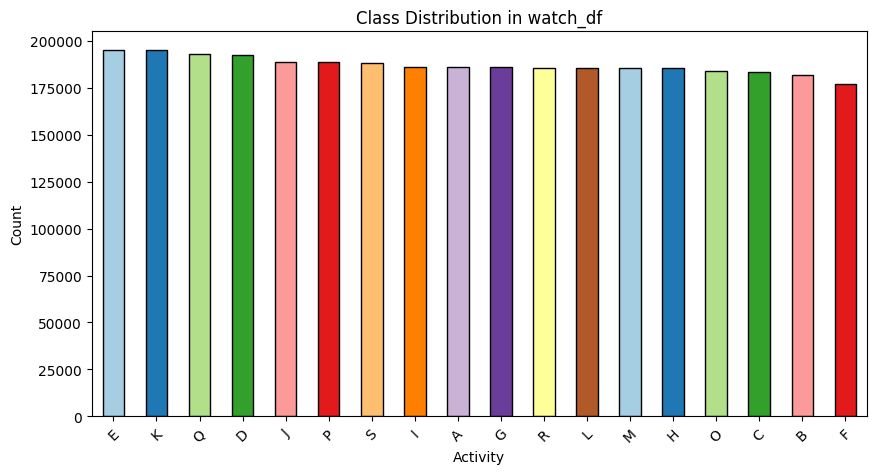

In [ ]:
# Count occurrences of each activity
class_counts = watch_df['Activity'].value_counts()

# Generate different colors for each bar
colors = plt.cm.Paired.colors[:len(class_counts)]  # Using 'Paired' colormap for distinct colors

# Print class distribution
print("Class Distribution:\n", class_counts)

# Plot the class distribution
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar', color=colors, edgecolor='black')

# Labels and title
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Class Distribution in watch_df")
plt.xticks(rotation=45)
plt.show()

In [ ]:
watch_df.head()

,Subject,Activity,Timestamp,Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z
0,1600,A,90426757696641,4.972757,-0.158317,6.696732,0.314944,-1.022277,-0.309962
1,1600,A,90426807196641,3.253720,-0.191835,6.107758,0.387382,-0.618541,-0.048972
2,1600,A,90426856696641,2.801216,-0.155922,5.997625,0.070999,-0.209480,-0.195978
3,1600,A,90426906196641,3.770868,-1.051354,7.731027,0.037975,0.254976,-0.156563
4,1600,A,90426955696641,4.661511,0.169689,9.684695,0.073129,0.719431,-0.001035


#DATA PREPROCESSING

In [ ]:
activity_merge_map = {
    'A': 'Walking',
    'B': 'Jogging',
    'C': 'Stairs',
    'D': 'Sitting',
    'E': 'Standing',         # Standing
    'G': 'Standing',         # Brushing teeth
    'F': 'Writing',          # Typing
    'Q': 'Writing',          # Writing
    'R': 'Writing',          # Clapping (Hand activities)
    'K': 'Eating',           # Drinking from cup
    'I': 'Eating',           # Eating chips
    'P': 'Playing sports',   # Dribbling basketball
    'M': 'Playing sports',   # Kicking soccer ball
}

# Apply the mapping
watch_df['Activity'] = watch_df['Activity'].map(activity_merge_map)

# Drop rows with activities that were not in the mapping (i.e., become NaN)
watch_df = watch_df.dropna(subset=['Activity']).reset_index(drop=True)

# Display unique activity labels after merging
print("Remaining activity labels:", watch_df['Activity'].unique())

Remaining activity labels: ['Walking' 'Jogging' 'Stairs' 'Sitting' 'Standing' 'Writing' 'Eating'
 'Playing sports']


In [ ]:
# Define new alphabetical labels for the merged categories
final_label_map = {
    'Walking': 'A',
    'Jogging': 'B',
    'Stairs': 'C',
    'Sitting': 'D',
    'Standing': 'E',
    # 'Writing': 'F',
    # 'Eating': 'G',
    # 'Playing sports': 'H'
}
# Apply the new label mapping
watch_df['Activity'] = watch_df['Activity'].map(final_label_map)

# Confirm the transformation
print("Final activity labels:", watch_df['Activity'].unique())

Final activity labels: ['A' 'B' 'C' 'D' 'E' nan]


In [ ]:
# Apply Min-Max Normalization
from sklearn.preprocessing import StandardScaler

sensor_columns = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
scaler = StandardScaler()
watch_df_normalized = watch_df.copy()
watch_df_normalized[sensor_columns] = scaler.fit_transform(watch_df[sensor_columns])

In [ ]:
watch_df_normalized['Activity'].unique()

array(['A', 'B', 'C', 'D', 'E', nan], dtype=object)

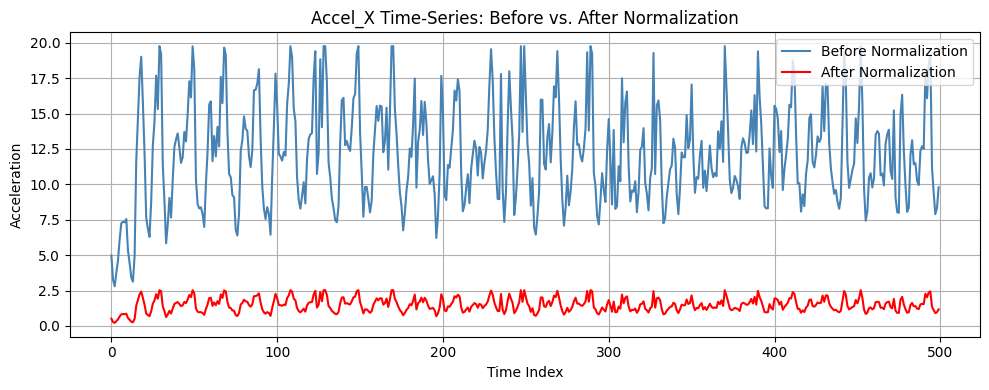

In [ ]:
# Time-Series Comparison: Before vs. After Normalization
plt.figure(figsize=(10, 4))
plt.plot(watch_df['Accel_X'][:500], label='Before Normalization', color='steelblue')
plt.plot(watch_df_normalized['Accel_X'][:500], label='After Normalization', color='red')
plt.title("Accel_X Time-Series: Before vs. After Normalization")
plt.xlabel("Time Index")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# # Take a random 50% sample of the dataset
# watch_df_sample = watch_df.sample(frac=0.5, random_state=42)

# # Save only the sample to CSV
# watch_df_sample.to_csv('/content/drive/MyDrive/HAR Data & Models/wisdm_watch_df.csv', index=False)

In [ ]:
def check_signal_variability(df):
    """
    Computes variance and IQR for each sensor column to detect potential noise.

    Args:
        df (DataFrame): The sensor data.
    """
    stats = df[['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']].describe()
    variance = stats.loc['std'] ** 2  # Variance is squared standard deviation
    iqr = stats.loc['75%'] - stats.loc['25%']  # Interquartile range (IQR)

    print("\n **Variance of Signals:**\n", variance)
    print("\n **Interquartile Range (IQR):**\n", iqr)

# Run the function
check_signal_variability(watch_df_normalized)


 **Variance of Signals:**
 Accel_X    1.0
Accel_Y    1.0
Accel_Z    1.0
Gyro_X     1.0
Gyro_Y     1.0
Gyro_Z     1.0
Name: std, dtype: float64

 **Interquartile Range (IQR):**
 Accel_X    1.640306
Accel_Y    1.132001
Accel_Z    1.284598
Gyro_X     0.400092
Gyro_Y     0.274105
Gyro_Z     0.308157
dtype: float64


In [ ]:
watch_df_normalized.head()

,Subject,Activity,Timestamp,Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z
0,1600,A,90426757696641,0.512083,0.716824,0.847386,0.224756,-0.649347,-0.224459
1,1600,A,90426807196641,0.277946,0.710509,0.730801,0.271918,-0.383747,-0.046470
2,1600,A,90426856696641,0.216314,0.717275,0.709001,0.065930,-0.114642,-0.146725
3,1600,A,90426906196641,0.348383,0.548565,1.052121,0.044430,0.190903,-0.119845
4,1600,A,90426955696641,0.469690,0.778624,1.438842,0.067317,0.496449,-0.013778


In [ ]:
import pandas as pd
import numpy as np


# Set parameters
sampling_rate = 20  # Hz
window_duration = 3  # seconds
window_size = sampling_rate * window_duration  # 60
step_size = int(window_size * 0.4)  # 60% overlap


# Select only the necessary columns
sensor_cols =['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
X_segments = []
y_labels = []

# Sort the dataframe to make sure the order is correct
watch_df_normalized = watch_df_normalized.sort_values(by=["Subject", "Activity", "Timestamp"]).reset_index(drop=True)

# Group by Subject and Activity
for (subject, activity), group in watch_df.groupby(["Subject", "Activity"]):
    group = group.reset_index(drop=True)

    # Slide a window over the group
    for start in range(0, len(group) - window_size + 1, step_size):
        end = start + window_size
        segment = group.iloc[start:end]

        # Ensure the segment is continuous and from the same subject/activity
        if len(segment) == window_size:
            X_segments.append(segment[sensor_cols].values)
            y_labels.append(activity)

# Convert to numpy arrays
X = np.array(X_segments)  # Shape: (num_samples, 60, 6)
y = np.array(y_labels)    # Shape: (num_samples,)

# Optionally convert to pandas DataFrame (if you want to use it as DataFrame)
X_df = pd.DataFrame({'features': list(X)})
y_df = pd.Series(y, name='Activity')

# Show shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (46351, 60, 6)
y shape: (46351,)


In [ ]:
X

array([[[ 4.97275700e+00, -1.58316580e-01,  6.69673160e+00,
          3.14944100e-01, -1.02227650e+00, -3.09961600e-01],
        [ 3.25372000e+00, -1.91835420e-01,  6.10775800e+00,
          3.87382100e-01, -6.18541240e-01, -4.89718020e-02],
        [ 2.80121600e+00, -1.55922380e-01,  5.99762500e+00,
          7.09985400e-02, -2.09479720e-01, -1.95978300e-01],
        ...,
        [ 1.00005810e+01, -4.04919360e-01, -2.31264930e+00,
         -3.91417030e-01,  1.53587160e-02, -2.47246600e+00],
        [ 1.22798605e+01, -1.85819980e+00,  4.78990000e-01,
         -1.80395770e+00, -1.71463070e+00, -4.63921360e+00],
        [ 1.56341370e+01, -1.69299980e+00,  7.71082600e-01,
         -1.89343990e+00, -3.00786160e+00, -5.83124450e+00]],

       [[ 8.76756700e+00, -2.83503410e+00,  1.00706110e-01,
         -1.76219780e-01, -7.01574600e-01, -2.11133860e+00],
        [ 1.27323650e+01, -4.65462730e+00,  4.90961000e-01,
          5.66269500e-01, -7.17553600e-01, -2.22106100e+00],
        [ 1.44490

In [ ]:
import pandas as pd

# Load your test CSV
test_csv = "/content/drive/MyDrive/HAR Data & Models/sb_IMU.csv"
test_df = pd.read_csv(test_csv)

In [ ]:
test_df.head()

,PC_Timestamp,BatteryPercent,IMU_Timestamp,Label,StepCount,Distance,Speed,AccelMagnitude,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z
0,2025-07-12T15:45:34.954555,0,33,0,0,0.0,0.0,0.896,0.156,0.704,-0.531,-54.984,-192.234,57.359
1,2025-07-12T15:45:35.014234,0,66,0,0,0.0,0.0,1.001,0.291,0.661,-0.694,-91.625,-274.812,174.188
2,2025-07-12T15:45:35.059198,0,99,0,0,0.0,0.0,0.977,0.175,0.733,-0.622,-104.641,-512.000,292.844
3,2025-07-12T15:45:35.119193,0,132,0,0,0.0,0.0,1.035,0.375,0.832,-0.490,-15.609,-512.000,403.766
4,2025-07-12T15:45:35.179177,0,165,0,0,0.0,0.0,0.893,0.064,0.769,-0.449,206.734,-512.000,419.125


In [ ]:
import pandas as pd


# Merge labels: convert 6 → 5
test_df["Label"] = test_df["Label"].replace({6: 5})

# Check unique labels after merging
print("Unique labels:", test_df["Label"].unique())

# (Optional) Save updated dataset
# df.to_csv("your_dataset_merged.csv", index=False)

Unique labels: [0 1 5 2 3 4]


In [ ]:
# Drop rows where Label == 0
test_df = test_df[test_df["Label"] != 0]

# Reset index (optional, cleaner)
test_df = test_df.reset_index(drop=True)

print(test_df["Label"].unique())
# print(test_df.head())

[1 5 2 3 4]


In [ ]:
test_df.head()

,PC_Timestamp,BatteryPercent,IMU_Timestamp,Label,StepCount,Distance,Speed,AccelMagnitude,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z
0,2025-07-12T15:47:06.080034,0,53955,1,0,0.0,0.0,0.933,0.048,0.032,-0.931,-5.781,12.781,3.047
1,2025-07-12T15:47:06.155062,0,53988,1,0,0.0,0.0,0.845,0.095,0.013,-0.839,16.859,-3.953,28.984
2,2025-07-12T15:47:06.215188,0,54021,1,0,0.0,0.0,0.671,-0.125,-0.141,-0.644,26.438,90.781,70.609
3,2025-07-12T15:47:06.275201,0,54054,1,0,0.0,0.0,0.723,0.074,-0.154,-0.702,66.953,192.922,150.125
4,2025-07-12T15:47:06.335189,0,54087,1,0,0.0,0.0,0.803,0.056,-0.268,-0.755,166.312,17.750,209.516


In [ ]:
# Map numeric labels to A–E
label_map = {
    1: "A",  # Walking
    2: "B",  # Jogging / Running
    3: "C",  # Stairs
    4: "D",  # Sitting
    5: "E"   # Standing
}

# Replace labels in the dataframe
test_df["Label"] = test_df["Label"].map(label_map)


In [ ]:
test_df.head()

,PC_Timestamp,BatteryPercent,IMU_Timestamp,Label,StepCount,Distance,Speed,AccelMagnitude,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z
0,2025-07-12T15:47:06.080034,0,53955,A,0,0.0,0.0,0.933,0.048,0.032,-0.931,-5.781,12.781,3.047
1,2025-07-12T15:47:06.155062,0,53988,A,0,0.0,0.0,0.845,0.095,0.013,-0.839,16.859,-3.953,28.984
2,2025-07-12T15:47:06.215188,0,54021,A,0,0.0,0.0,0.671,-0.125,-0.141,-0.644,26.438,90.781,70.609
3,2025-07-12T15:47:06.275201,0,54054,A,0,0.0,0.0,0.723,0.074,-0.154,-0.702,66.953,192.922,150.125
4,2025-07-12T15:47:06.335189,0,54087,A,0,0.0,0.0,0.803,0.056,-0.268,-0.755,166.312,17.750,209.516


In [ ]:
from sklearn.preprocessing import StandardScaler

sensor_columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
scaler = StandardScaler()
test_df_normalized = test_df.copy()
test_df_normalized[sensor_columns] = scaler.fit_transform(test_df[sensor_columns])

In [ ]:
def check_signal_variability(df):
    """
    Computes variance and IQR for each sensor column to detect potential noise.

    Args:
        df (DataFrame): The sensor data.
    """
    stats = df[['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']].describe()
    variance = stats.loc['std'] ** 2  # Variance is squared standard deviation
    iqr = stats.loc['75%'] - stats.loc['25%']  # Interquartile range (IQR)

    print("\n **Variance of Signals:**\n", variance)
    print("\n **Interquartile Range (IQR):**\n", iqr)

# Run the function
check_signal_variability(test_df_normalized)


 **Variance of Signals:**
 Acc_X     1.000011
Acc_Y     1.000011
Acc_Z     1.000011
Gyro_X    1.000011
Gyro_Y    1.000011
Gyro_Z    1.000011
Name: std, dtype: float64

 **Interquartile Range (IQR):**
 Acc_X     0.413118
Acc_Y     1.202454
Acc_Z     1.132239
Gyro_X    0.408711
Gyro_Y    0.446843
Gyro_Z    0.635654
dtype: float64


In [ ]:
test_df_normalized.head()

,PC_Timestamp,BatteryPercent,IMU_Timestamp,Label,StepCount,Distance,Speed,AccelMagnitude,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z
0,2025-07-12T15:47:06.080034,0,53955,A,0,0.0,0.0,0.933,-0.591433,0.739681,-0.975291,-0.085694,0.065330,0.011760
1,2025-07-12T15:47:06.155062,0,53988,A,0,0.0,0.0,0.845,-0.524014,0.713269,-0.817464,0.100125,-0.047590,0.130332
2,2025-07-12T15:47:06.215188,0,54021,A,0,0.0,0.0,0.671,-0.839590,0.499190,-0.482939,0.178745,0.591671,0.320622
3,2025-07-12T15:47:06.275201,0,54054,A,0,0.0,0.0,0.723,-0.554137,0.481118,-0.582439,0.511273,1.280914,0.684133
4,2025-07-12T15:47:06.335189,0,54087,A,0,0.0,0.0,0.803,-0.579957,0.322645,-0.673361,1.326766,0.098861,0.955641


In [ ]:
# from sklearn.model_selection import train_test_split

# # Convert X and y to numpy arrays if they aren't already
# X = np.array(X)
# y = np.array(y)

# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# print("Training shape:", X_train.shape, y_train.shape)
# print("Testing shape:", X_test.shape, y_test.shape)

In [ ]:
import pandas as pd
import numpy as np

# Training data (already segmented numpy arrays)
X_train = np.array(X)
y_train = np.array(y)

print("Training shape:", X_train.shape, y_train.shape)

# Columns
sensor_cols = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
label_col = "Label"


# --- Segmentation parameters (same as training) ---
sampling_rate = 20        # Hz
window_duration = 3       # seconds
window_size = sampling_rate * window_duration  # 60 timesteps
step_size = int(window_size * 0.4)             # 60% overlap

X_test_segments = []
y_test_labels = []

# Only group by Label since Subject column doesn't exist
for label, group in test_df.groupby("Label"):
    group = group.reset_index(drop=True)

    for start in range(0, len(group) - window_size + 1, step_size):
        end = start + window_size
        segment = group.iloc[start:end]

        if len(segment) == window_size:
            X_test_segments.append(segment[sensor_cols].values)
            # Label = majority vote in the window
            y_test_labels.append(segment[label_col].mode()[0])

# Convert to numpy arrays
X_test = np.array(X_test_segments)   # shape: (num_samples, 60, 6)
y_test = np.array(y_test_labels)

print("Testing shape:", X_test.shape, y_test.shape)

Training shape: (46351, 60, 6) (46351,)
Testing shape: (3865, 60, 6) (3865,)


In [ ]:
y_train

array(['A', 'A', 'A', ..., 'E', 'E', 'E'], dtype='<U1')

In [ ]:
np.unique(y_test)

array(['A', 'B', 'C', 'D', 'E'], dtype='<U1')

In [ ]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
print( X_train.shape[1]) #no of samples in a window
print( X_train.shape[2]) #no of input features
len(np.unique(y_train)) #no of unique activities

60
6


5

In [ ]:
# Step 2: Convert the integer labels to one-hot encoding
num_classes = len(np.unique(y_train))  # Number of unique classes
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("One-hot encoded labels:")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

One-hot encoded labels:
y_train shape: (46351, 5)
y_test shape: (3865, 5)


In [ ]:
y_train #after one hot encoded

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

def display_results(y_true, y_pred, classNames):
    # Convert one-hot encoded labels to class indices if needed
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)

    # Classification Report
    print("\n**** Classification Report ****")
    print(classification_report(y_true, y_pred, target_names=classNames))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

#1D-CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import keras_tuner as kt

# Reshape data for Conv1D
X_train_reshaped = X_train.reshape((X_train.shape[0], 60, 6))
X_test_reshaped = X_test.reshape((X_test.shape[0], 60, 6))

num_classes = y_train.shape[1]

# Hypermodel definition
def build_model(hp):
    model = Sequential()

    # First Conv1D layer
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        padding='same',
        input_shape=(60, 6)
    ))
    model.add(MaxPooling1D(pool_size=2))

    # Second Conv1D layer
    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu',
        padding='same'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))

    # Dropout
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,   # number of different hyperparameter combinations to try
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='1dcnn'
)

# Search for best parameters
tuner.search(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best parameters:
Filters 1: {best_hps.get('filters_1')}
Filters 2: {best_hps.get('filters_2')}
Kernel size 1: {best_hps.get('kernel_size')}
Kernel size 2: {best_hps.get('kernel_size_2')}
Dense units: {best_hps.get('dense_units')}
Dropout: {best_hps.get('dropout_rate')}
Learning rate: {best_hps.get('learning_rate')}
""")

# Train best model
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(
#     X_train_reshaped, y_train,
#     validation_data=(X_test_reshaped, y_test),
#     epochs=20,
#     batch_size=32,
#     verbose=1
# )

Trial 10 Complete [00h 04m 58s]
val_accuracy: 0.9608456492424011

Best val_accuracy So Far: 0.9608456492424011
Total elapsed time: 01h 29m 28s

Best parameters:
Filters 1: 64
Filters 2: 128
Kernel size 1: 5
Kernel size 2: 3
Dense units: 64
Dropout: 0.6000000000000001
Learning rate: 0.001



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import keras_tuner as kt

#CNN Model using the best parameters
# Reshape for Conv1D
X_train_reshaped = X_train.reshape((X_train.shape[0], 60, 6))
X_test_reshaped = X_test.reshape((X_test.shape[0], 60, 6))

num_classes = y_train.shape[1]

# Build model with best parameters
model_1d_cnn = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=(60, 6)),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.6000000000000001),
    Dense(num_classes, activation='softmax')
])

# Compile
model_1d_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with EarlyStopping & save best model
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     # tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HAR Data & Models/wisdm_final_1dcnn_model.h5', save_best_only=True, monitor='val_loss')
# ]



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Ensure the model is built (important!)
model_1d_cnn.build(input_shape=(None, 60, 6))


In [ ]:
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=50,  # can stop early if no improvement
    batch_size=64,
    verbose=1,
    # callbacks=callbacks
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Precision, Recall, F1 (macro for multi-class)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy : 0.1746
Precision: 0.1222
Recall   : 0.1666
F1 Score : 0.1087


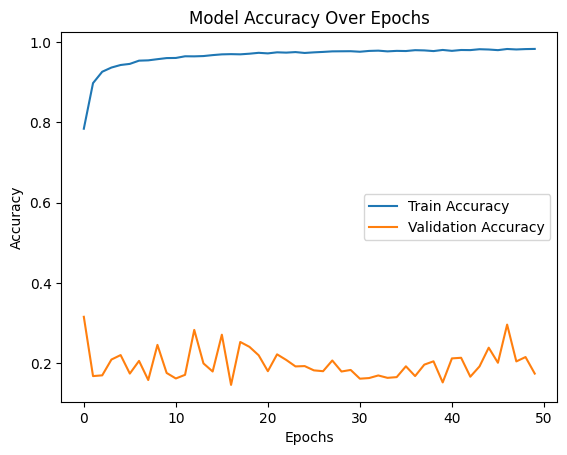

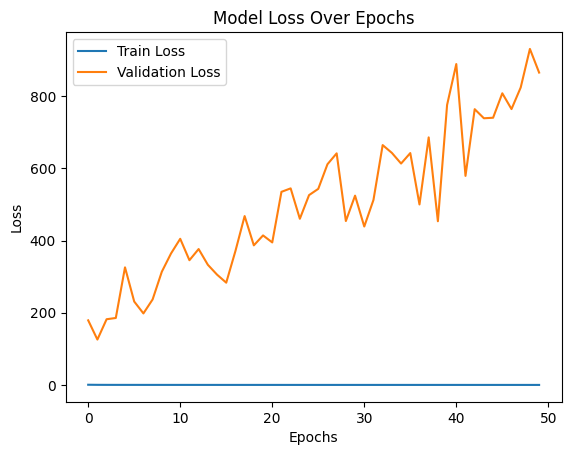

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,873 (1.72 MB)

 Trainable params: 149,957 (585.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 299,916 (1.14 MB)

In [ ]:
batch_size = 64
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.17464424669742584
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step



**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.07      0.07      0.07       796
     Jogging       0.04      0.01      0.01       652
      Stairs       0.21      0.66      0.31       826
     Sitting       0.30      0.10      0.15       725
    Standing       0.00      0.00      0.00       866

    accuracy                           0.17      3865
   macro avg       0.12      0.17      0.11      3865
weighted avg       0.12      0.17      0.11      3865



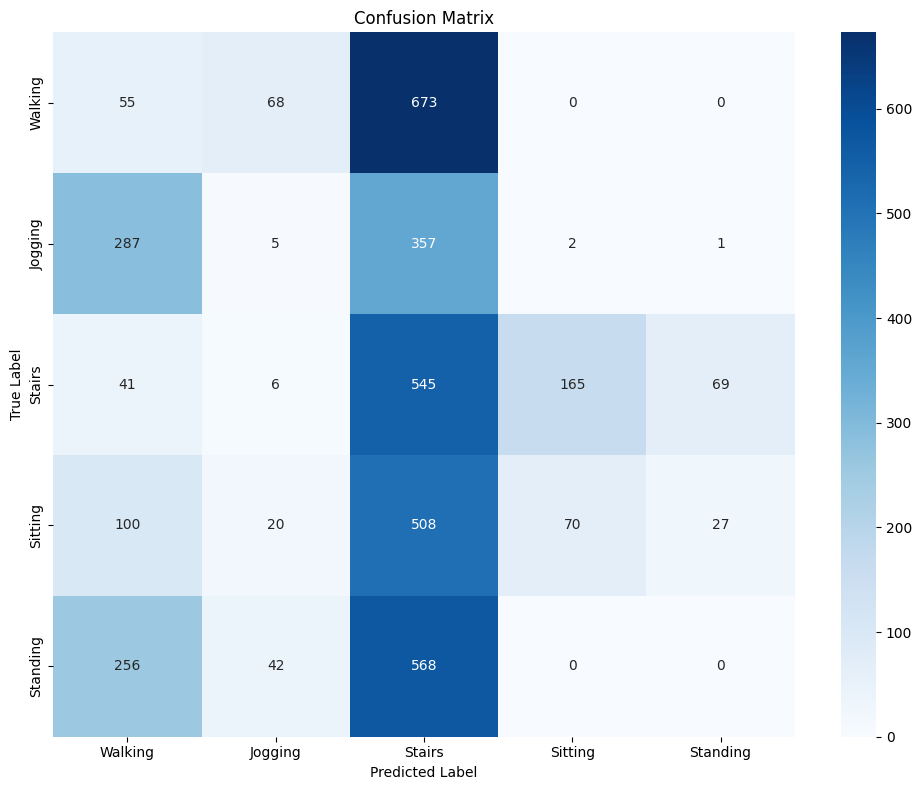

In [ ]:
classNames=['Walking','Jogging','Stairs','Sitting',
    'Standing',
    # 'Writing',
    # 'Eating',
    # 'Playing sports'
]
y_test_labels = np.argmax(y_test, axis=1)

# Convert predictions from probabilities to class labels (integer class labels)
predictions_labels = np.argmax(predictions, axis=1)
display_results(y_test_labels, predictions_labels, classNames)

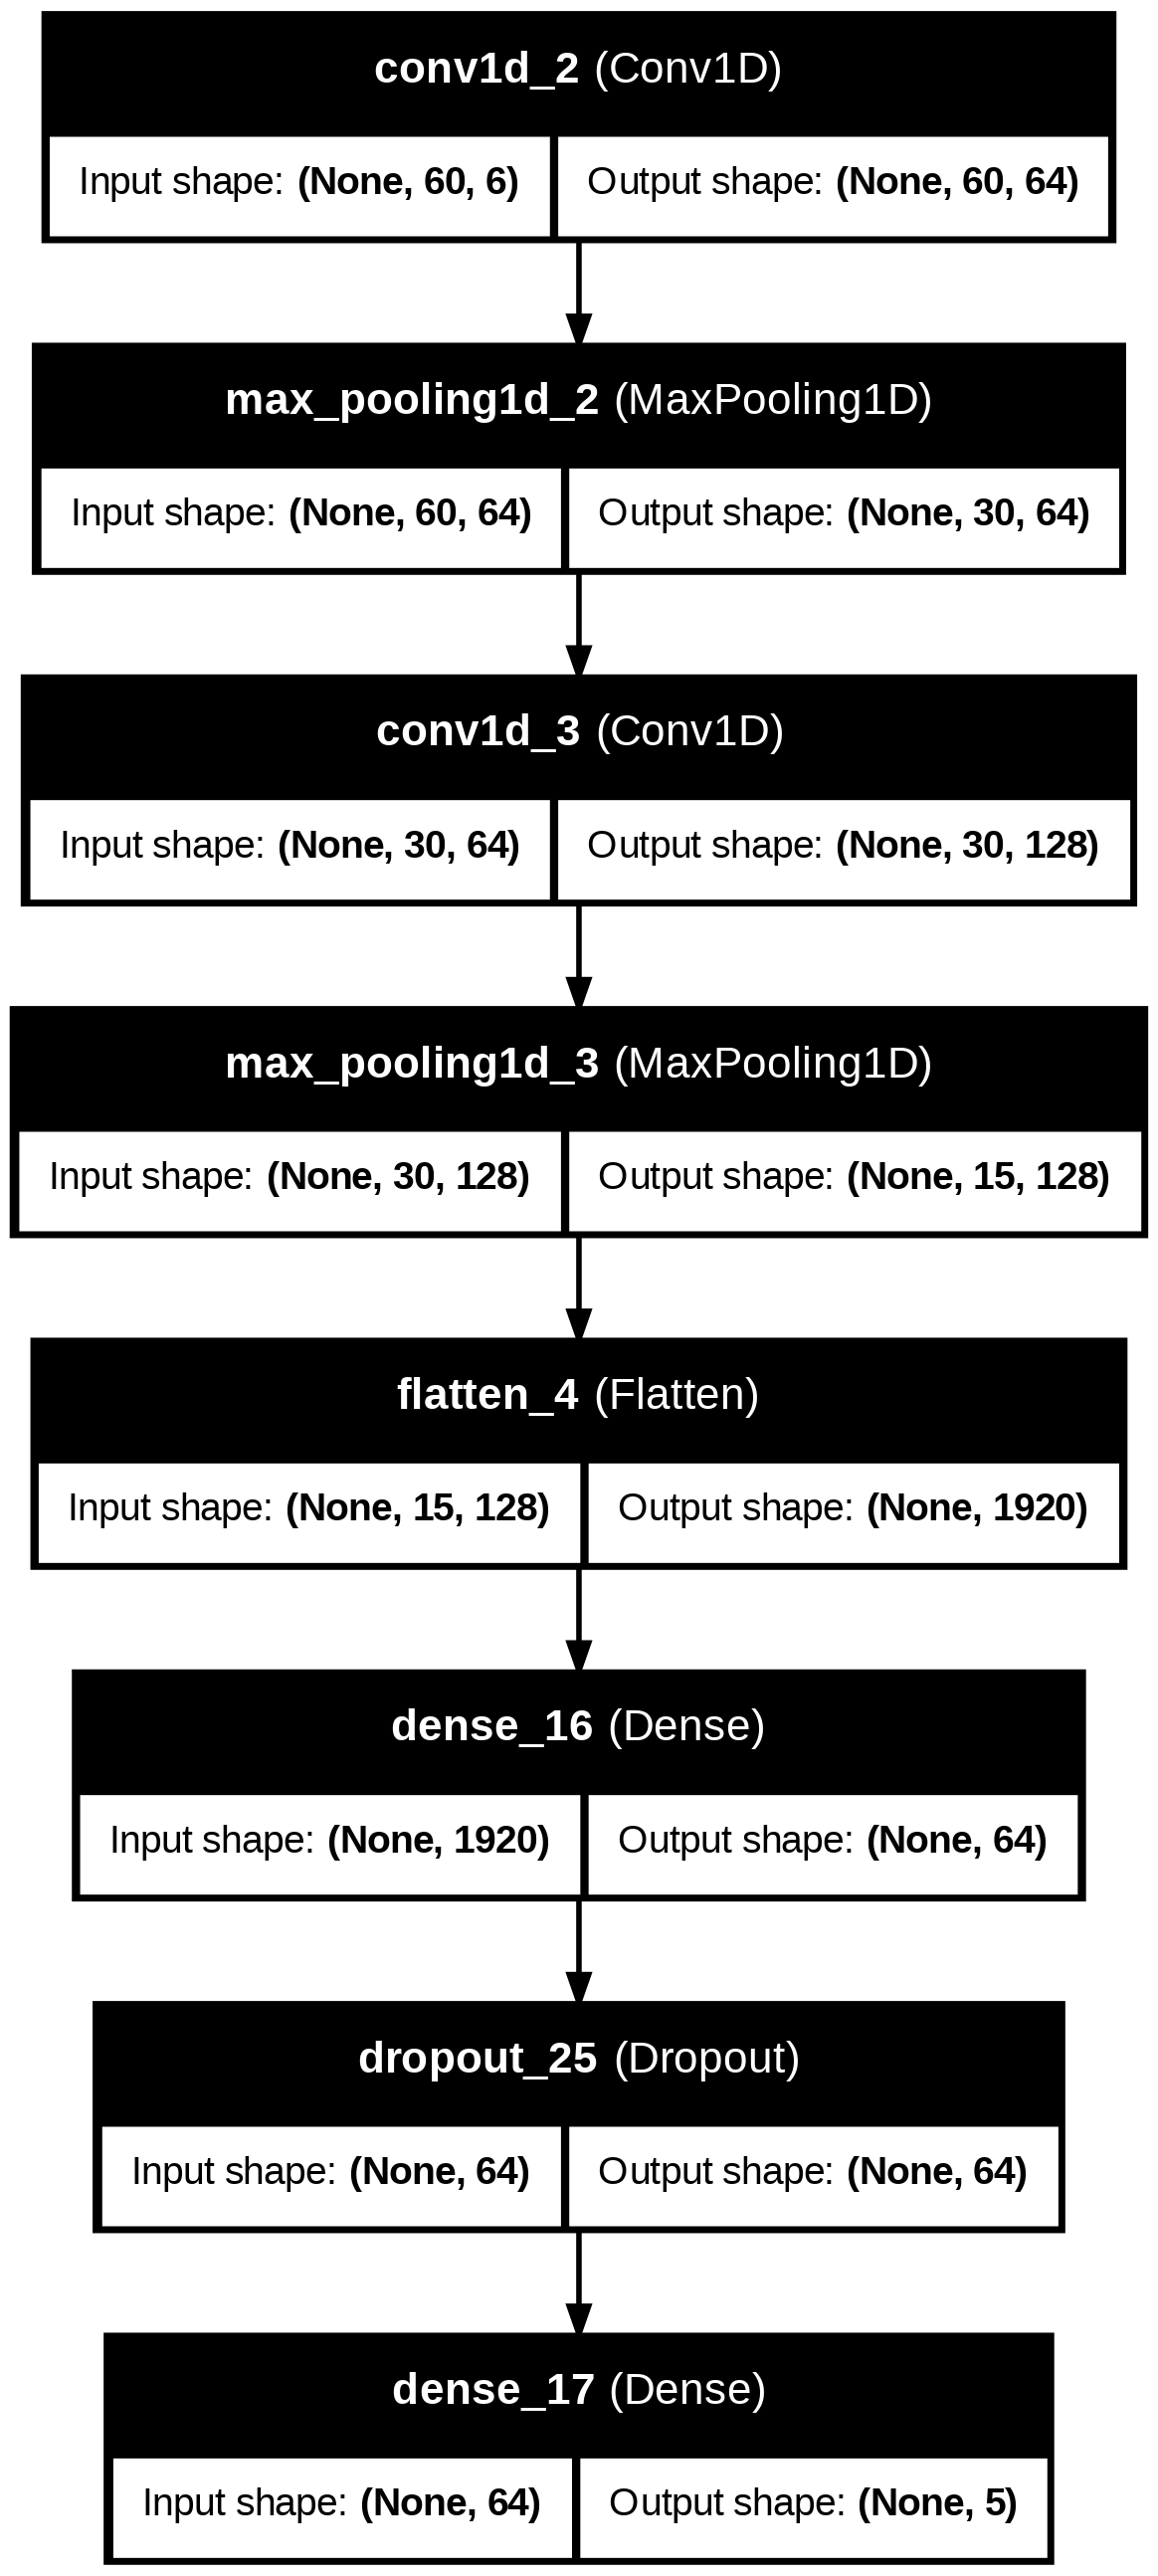

In [ ]:
from tensorflow.keras.utils import plot_model

# Save model plot
plot_model(
    model_1d_cnn,
    to_file="1d_cnn_model_plot.png",
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
!pip install keras-visualizer

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.5 MB/s eta 0:00:00


In [ ]:
# Install (if not already)
# pip install keras-visualizer

from keras_visualizer import visualizer

# Save visualization of model
visualizer(model_1d_cnn, file_format = 'png' , view=True)

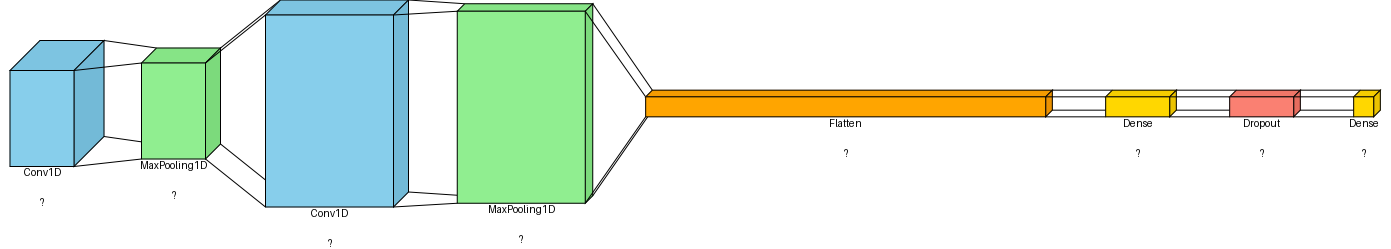

In [ ]:
import visualkeras
from PIL import ImageFont
import tensorflow as tf
import numpy as np

# Ensure model is built and shapes are propagated
dummy_input = np.random.rand(1, 60, 6).astype(np.float32)
_ = model_1d_cnn(dummy_input)   # run once to initialize shapes

# Load font
try:
    font = ImageFont.truetype("arial.ttf", 20)
except:
    font = ImageFont.load_default()

# Custom colors
color_map = {
    tf.keras.layers.Conv1D:       {"fill": "skyblue",   "outline": "black"},
    tf.keras.layers.MaxPooling1D: {"fill": "lightgreen","outline": "black"},
    tf.keras.layers.Flatten:      {"fill": "orange",    "outline": "black"},
    tf.keras.layers.Dense:        {"fill": "gold",      "outline": "black"},
    tf.keras.layers.Dropout:      {"fill": "salmon",    "outline": "black"},
}

# Force shape calculation for each layer
def text_draw(index, layer):
    class_name = layer.__class__.__name__
    try:
        # compute_output_shape if available
        if hasattr(layer, "compute_output_shape"):
            output_shape = layer.compute_output_shape(layer.input_shape)
        else:
            output_shape = layer.output_shape
        output_shape = str(output_shape)
    except Exception:
        output_shape = "?"
    return f"{class_name}\n{output_shape}", False

# Draw architecture diagram with actual output shapes
visualkeras.layered_view(
    model_1d_cnn,
    to_file="1d_cnn_architecture_with_shapes.png",
    legend=False,
    font=font,
    spacing=60,
    draw_funnel=True,
    color_map=color_map,
    scale_xy=1.5,
    scale_z=1.0,
    type_ignore=[tf.keras.layers.InputLayer],
    text_callable=text_draw,
    text_vspacing=20
)


#2D-CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras_tuner as kt

input_shape = (6, 60, 1)
num_classes = y_train.shape[1]

# Hypermodel definition
def build_model(hp):
    model = Sequential()

    # Conv Layer 1
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=input_shape
    ))
    model.add(MaxPooling2D((2, 2)))

    # Conv Layer 2
    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Dense Layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='tanh'
    ))

    # Dropout Layer
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Random Search Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,               # Try 10 combinations
    executions_per_trial=1,
    directory='2dcnn_tuning',
    project_name='random_search_2dcnn'
)

# Search
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best parameters:
Filters 1: {best_hps.get('filters_1')}
Filters 2: {best_hps.get('filters_2')}
Dense units: {best_hps.get('dense_units')}
Dropout rate: {best_hps.get('dropout_rate')}
Learning rate: {best_hps.get('learning_rate')}
""")

# Train final model with best params
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=20,
#     batch_size=32,
#     verbose=1
# )

# Evaluate
# loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
# print(f"Test Accuracy: {accuracy:.4f}")


Trial 10 Complete [00h 29m 43s]
val_accuracy: 0.3414543569087982

Best val_accuracy So Far: 0.9841701984405518
Total elapsed time: 03h 55m 11s

Best parameters:
Filters 1: 96
Filters 2: 128
Dense units: 64
Dropout rate: 0.5
Learning rate: 0.0001



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras_tuner as kt

# Dataset info
input_shape = (6, 60, 1)  # Matches X_train shape
num_classes = y_train.shape[1]

# Build final model with best params
model_2d_cnn = Sequential([
    Conv2D(96, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile with best learning rate
model_2d_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks for best model saving
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HAR Data & Models/wisdm_best_2dcnn_model.h5', save_best_only=True, monitor='val_loss')
# ]



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train model
history = model_2d_cnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,   # EarlyStopping will likely stop earlier
    batch_size=64,
    verbose=1,
    #callbacks=callbacks
)

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Precision, Recall, F1 (macro for multi-class)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Accuracy : 0.2013
Precision: 0.2240
Recall   : 0.1900
F1 Score : 0.1408


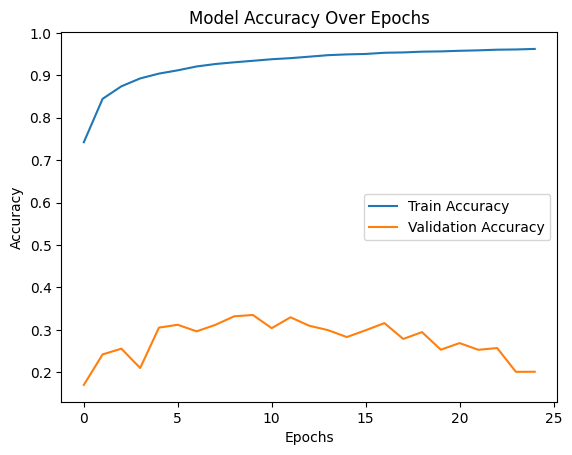

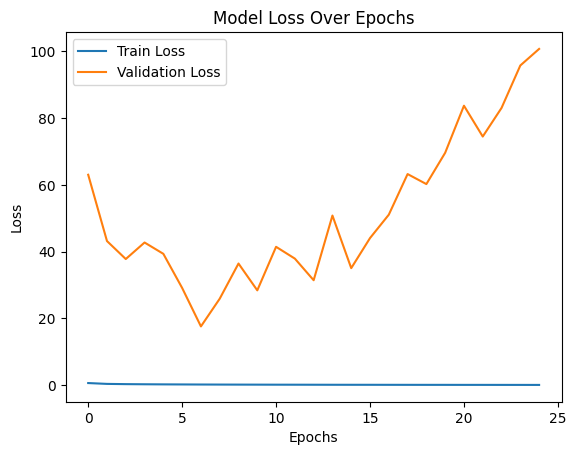

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 6, 60, 96)      │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 30, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 30, 128)     │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 15, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,849 (2.69 MB)

 Trainable params: 234,949 (917.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 469,900 (1.79 MB)

In [ ]:
batch_size = 64
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.20129366219043732
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step



**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.43      0.08      0.13       796
     Jogging       0.02      0.01      0.01       652
      Stairs       0.20      0.69      0.31       826
     Sitting       0.16      0.07      0.10       725
    Standing       0.31      0.10      0.16       866

    accuracy                           0.20      3865
   macro avg       0.22      0.19      0.14      3865
weighted avg       0.23      0.20      0.15      3865



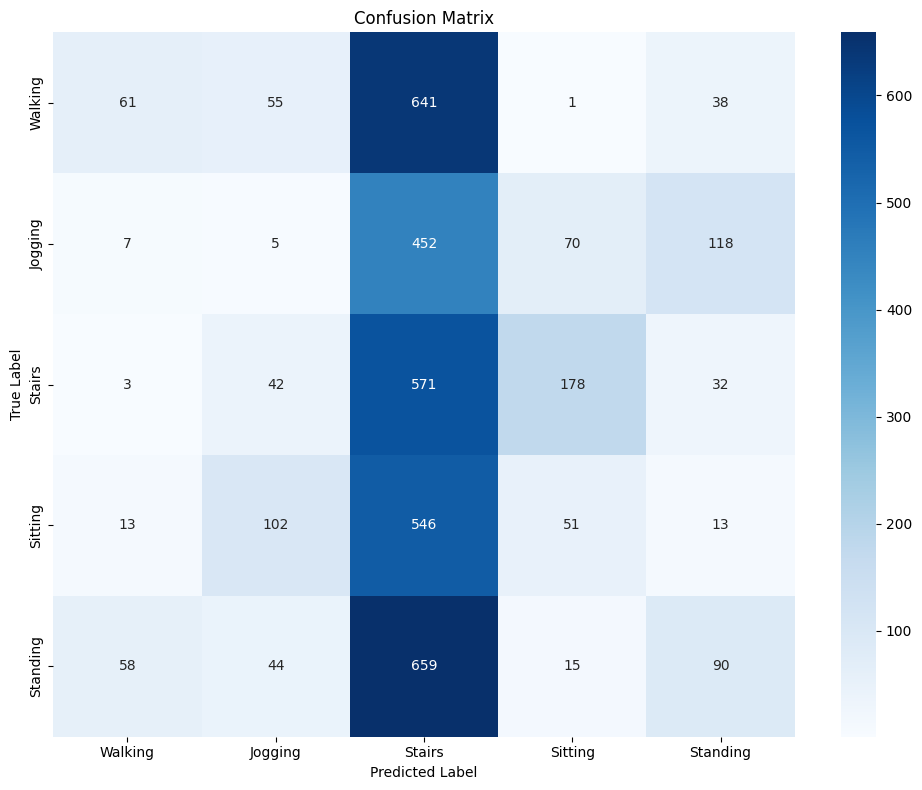

In [ ]:
classNames=['Walking','Jogging','Stairs','Sitting',
    'Standing',
    # 'Writing',
    # 'Eating',
    # 'Playing sports'
]
y_test_labels = np.argmax(y_test, axis=1)

# Convert predictions from probabilities to class labels (integer class labels)
predictions_labels = np.argmax(predictions, axis=1)
display_results(y_test_labels, predictions_labels, classNames)

In [ ]:
!pip install keras-visualizer

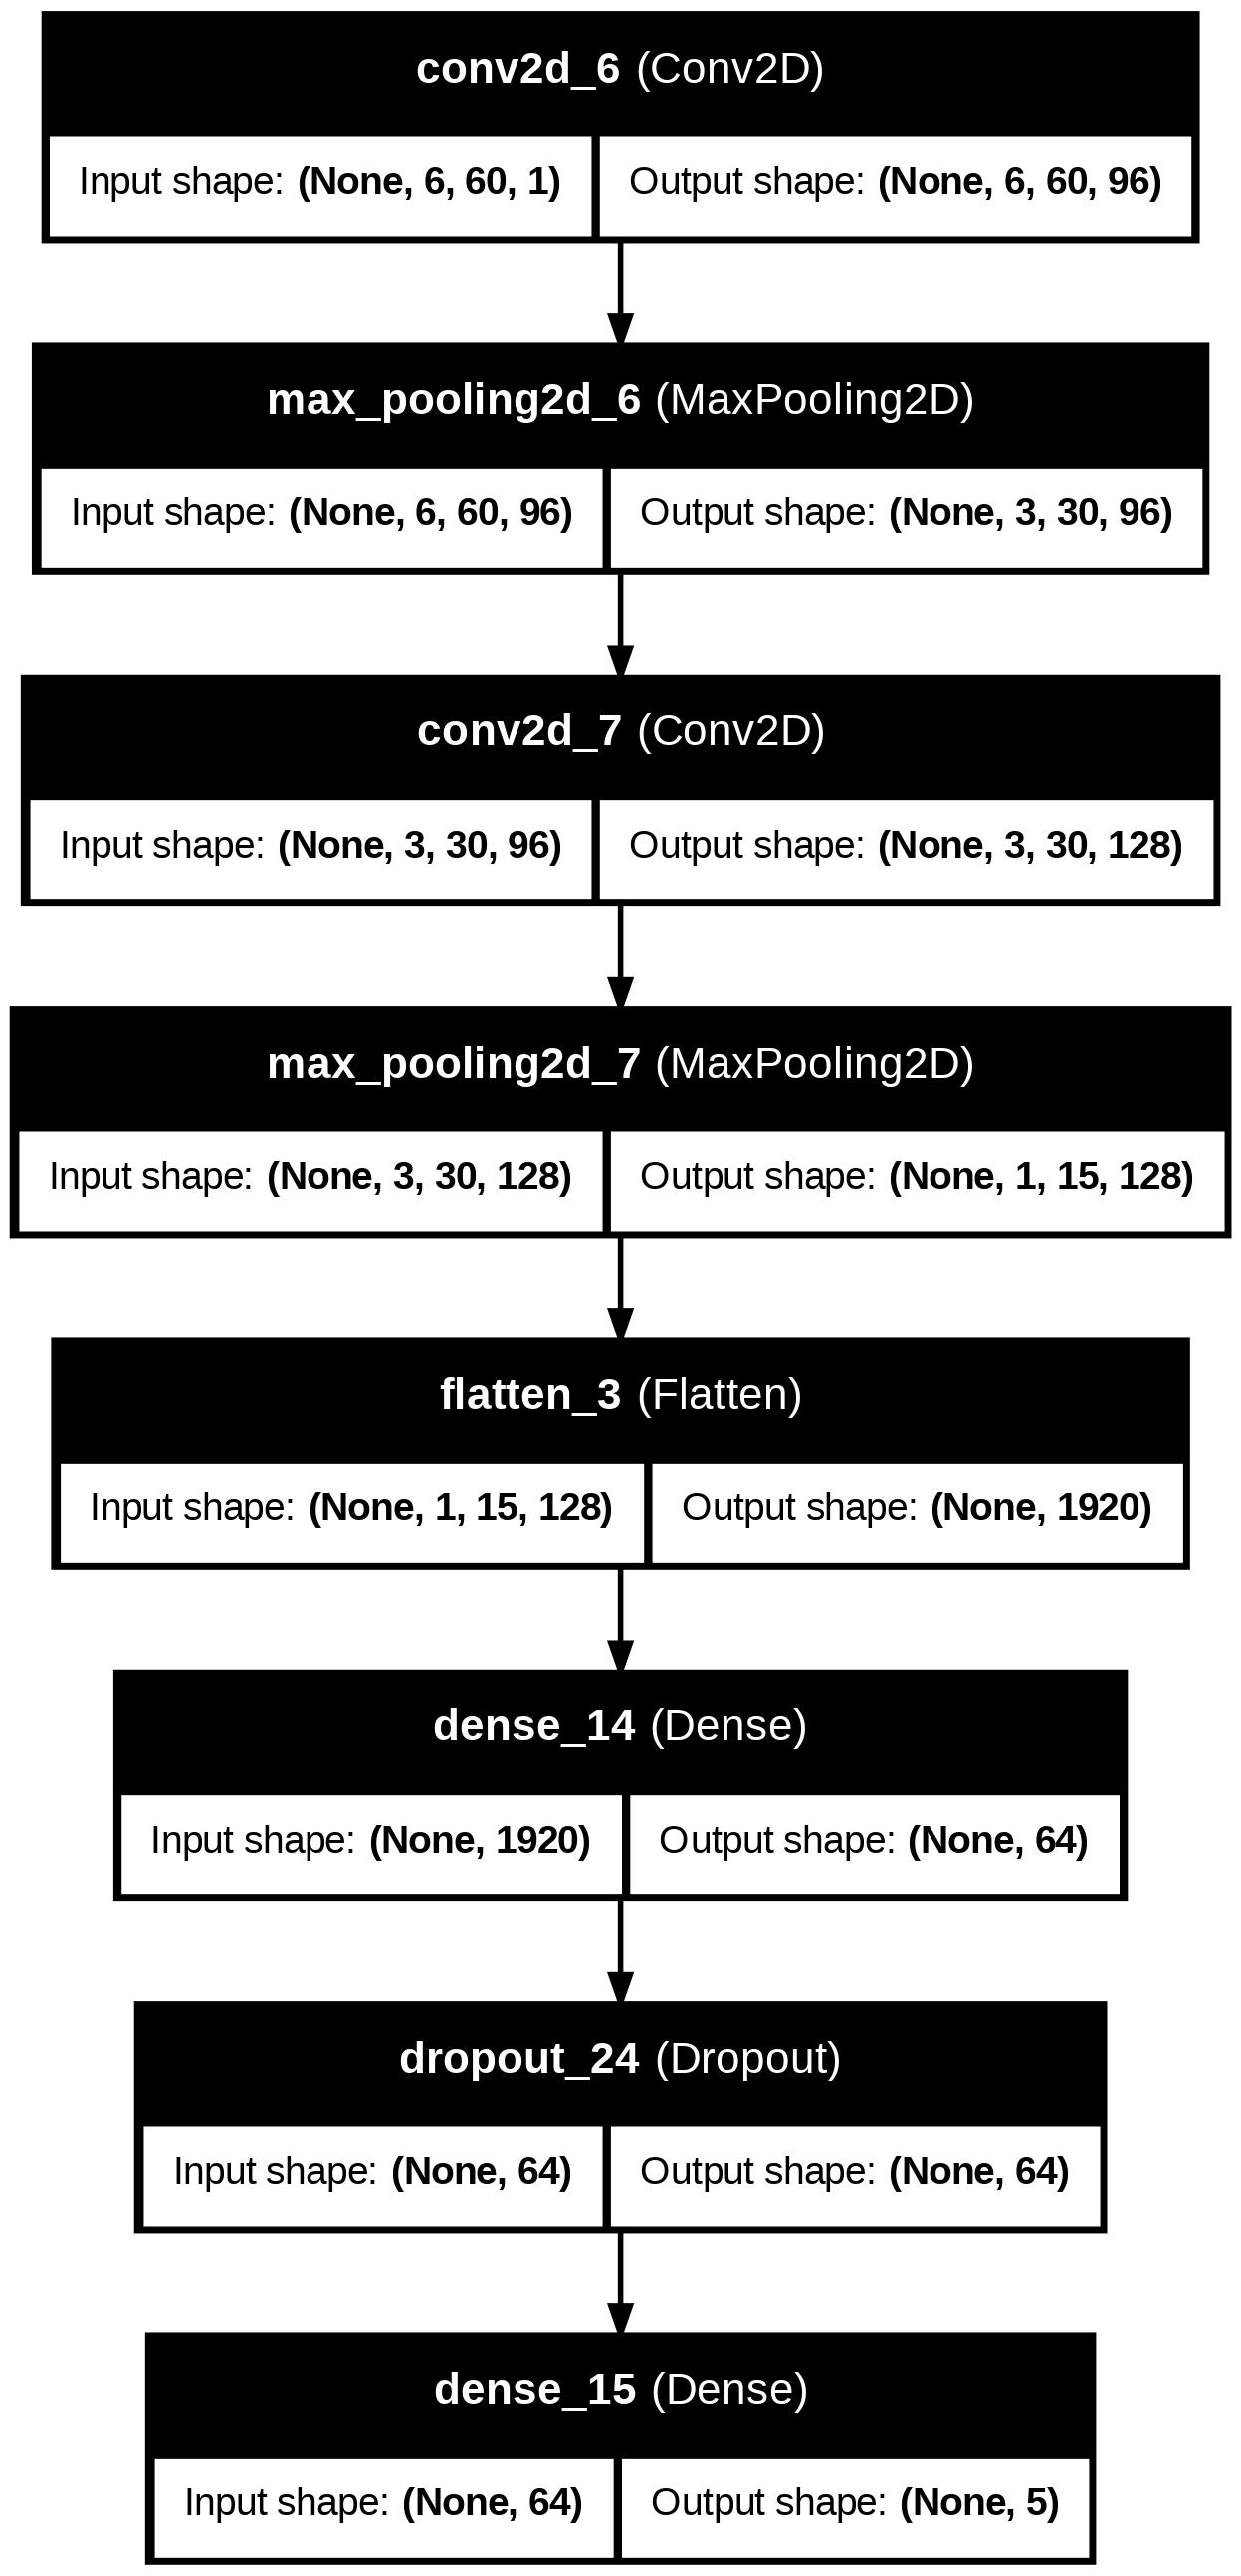

In [ ]:
from tensorflow.keras.utils import plot_model

# Save model plot
plot_model(
    model_2d_cnn,
    to_file="2d_cnn_model_plot.png",
    show_shapes=True,
    show_layer_names=True
)


#LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt

# Reshape data for LSTM: (samples, timesteps=60, features=6)
X_train_lstm = X_train.reshape((X_train.shape[0], 60, 6))
X_test_lstm = X_test.reshape((X_test.shape[0], 60, 6))

num_classes = y_train.shape[1]
input_shape = (60, 6)

# Hypermodel
def build_model(hp):
    model = Sequential([
        LSTM(
            units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=input_shape
        ),
        Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)),

        LSTM(
            units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)
        ),
        Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)),

        Dense(
            units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
            activation='relu'
        ),
        Dropout(hp.Float('dropout_3', 0.3, 0.6, step=0.1)),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Try 10 parameter combinations
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='original_architecture'
)

# Search
tuner.search(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Get best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best parameters:
LSTM 1 units: {best_hps.get('lstm_units_1')}
LSTM 2 units: {best_hps.get('lstm_units_2')}
Dense units: {best_hps.get('dense_units')}
Dropout 1: {best_hps.get('dropout_1')}
Dropout 2: {best_hps.get('dropout_2')}
Dropout 3: {best_hps.get('dropout_3')}
Learning rate: {best_hps.get('learning_rate')}
""")

# Train final model with best params
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(
#     X_train_lstm, y_train,
#     validation_data=(X_test_lstm, y_test),
#     epochs=20,
#     batch_size=32,
#     verbose=1
# )


Trial 10 Complete [01h 01m 34s]
val_accuracy: 0.9761315584182739

Best val_accuracy So Far: 0.979223370552063
Total elapsed time: 07h 32m 02s

Best parameters:
LSTM 1 units: 96
LSTM 2 units: 128
Dense units: 192
Dropout 1: 0.30000000000000004
Dropout 2: 0.30000000000000004
Dropout 3: 0.5
Learning rate: 0.0001



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Dataset info
input_shape = (60, 6)  # Reshaped LSTM input
num_classes = y_train.shape[1]

# Reshape the data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 60, 6))
X_test_lstm = X_test.reshape((X_test.shape[0], 60, 6))

# Build final LSTM model with best params
model_lstm = Sequential([
    LSTM(96, return_sequences=True, input_shape=input_shape),
    Dropout(0.30000000000000004),

    LSTM(128),
    Dropout(0.30000000000000004),

    Dense(192, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Compile with best learning rate
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks for best model saving
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HAR Data & Models/wisdm_best_lstm_model.h5', save_best_only=True, monitor='val_loss')
# ]



# # Save final trained model
# model.save("final_lstm_model.h5")
# print("Final model saved as final_lstm_model.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train model
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=20,   # EarlyStopping will likely stop earlier
    batch_size=64,
    verbose=1,
    #callbacks=callbacks
)

# Evaluate on test set
loss, accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Precision, Recall, F1 (macro for multi-class)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy : 0.2662
Precision: 0.1540
Recall   : 0.2573
F1 Score : 0.1643


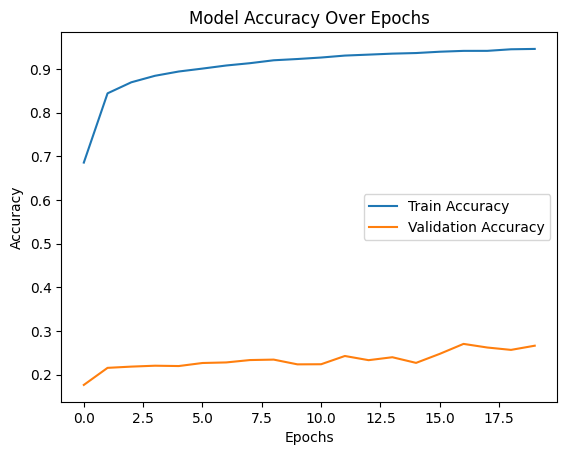

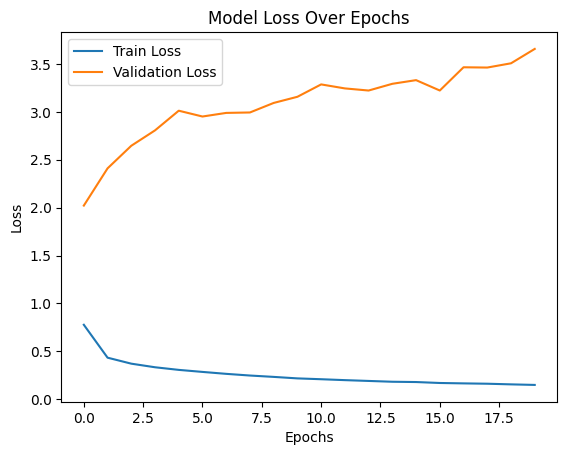

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 96)         │        39,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,457 (2.07 MB)

 Trainable params: 180,485 (705.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 360,972 (1.38 MB)

In [ ]:
batch_size = 64
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.26623544096946716
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step



**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.32      0.99      0.48       796
     Jogging       0.00      0.00      0.00       652
      Stairs       0.32      0.26      0.28       826
     Sitting       0.14      0.04      0.06       725
    Standing       0.00      0.00      0.00       866

    accuracy                           0.27      3865
   macro avg       0.15      0.26      0.16      3865
weighted avg       0.16      0.27      0.17      3865



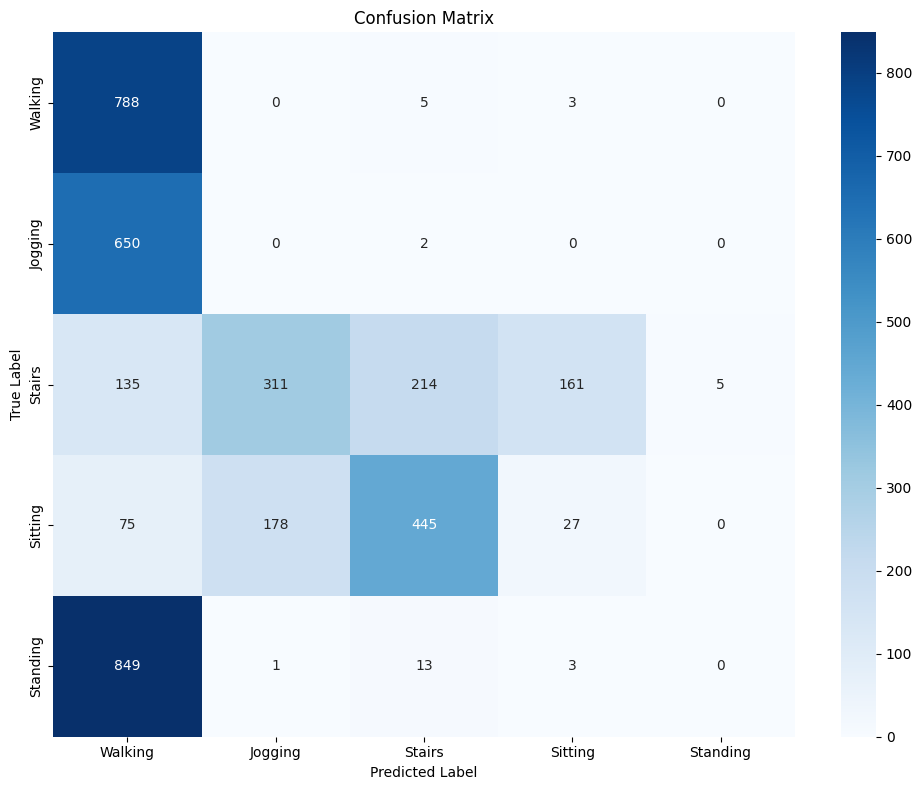

In [ ]:
classNames=['Walking','Jogging','Stairs','Sitting',
    'Standing',
    # 'Writing',
    # 'Eating',
    # 'Playing sports'
]
y_test_labels = np.argmax(y_test, axis=1)

# Convert predictions from probabilities to class labels (integer class labels)
predictions_labels = np.argmax(predictions, axis=1)
display_results(y_test_labels, predictions_labels, classNames)

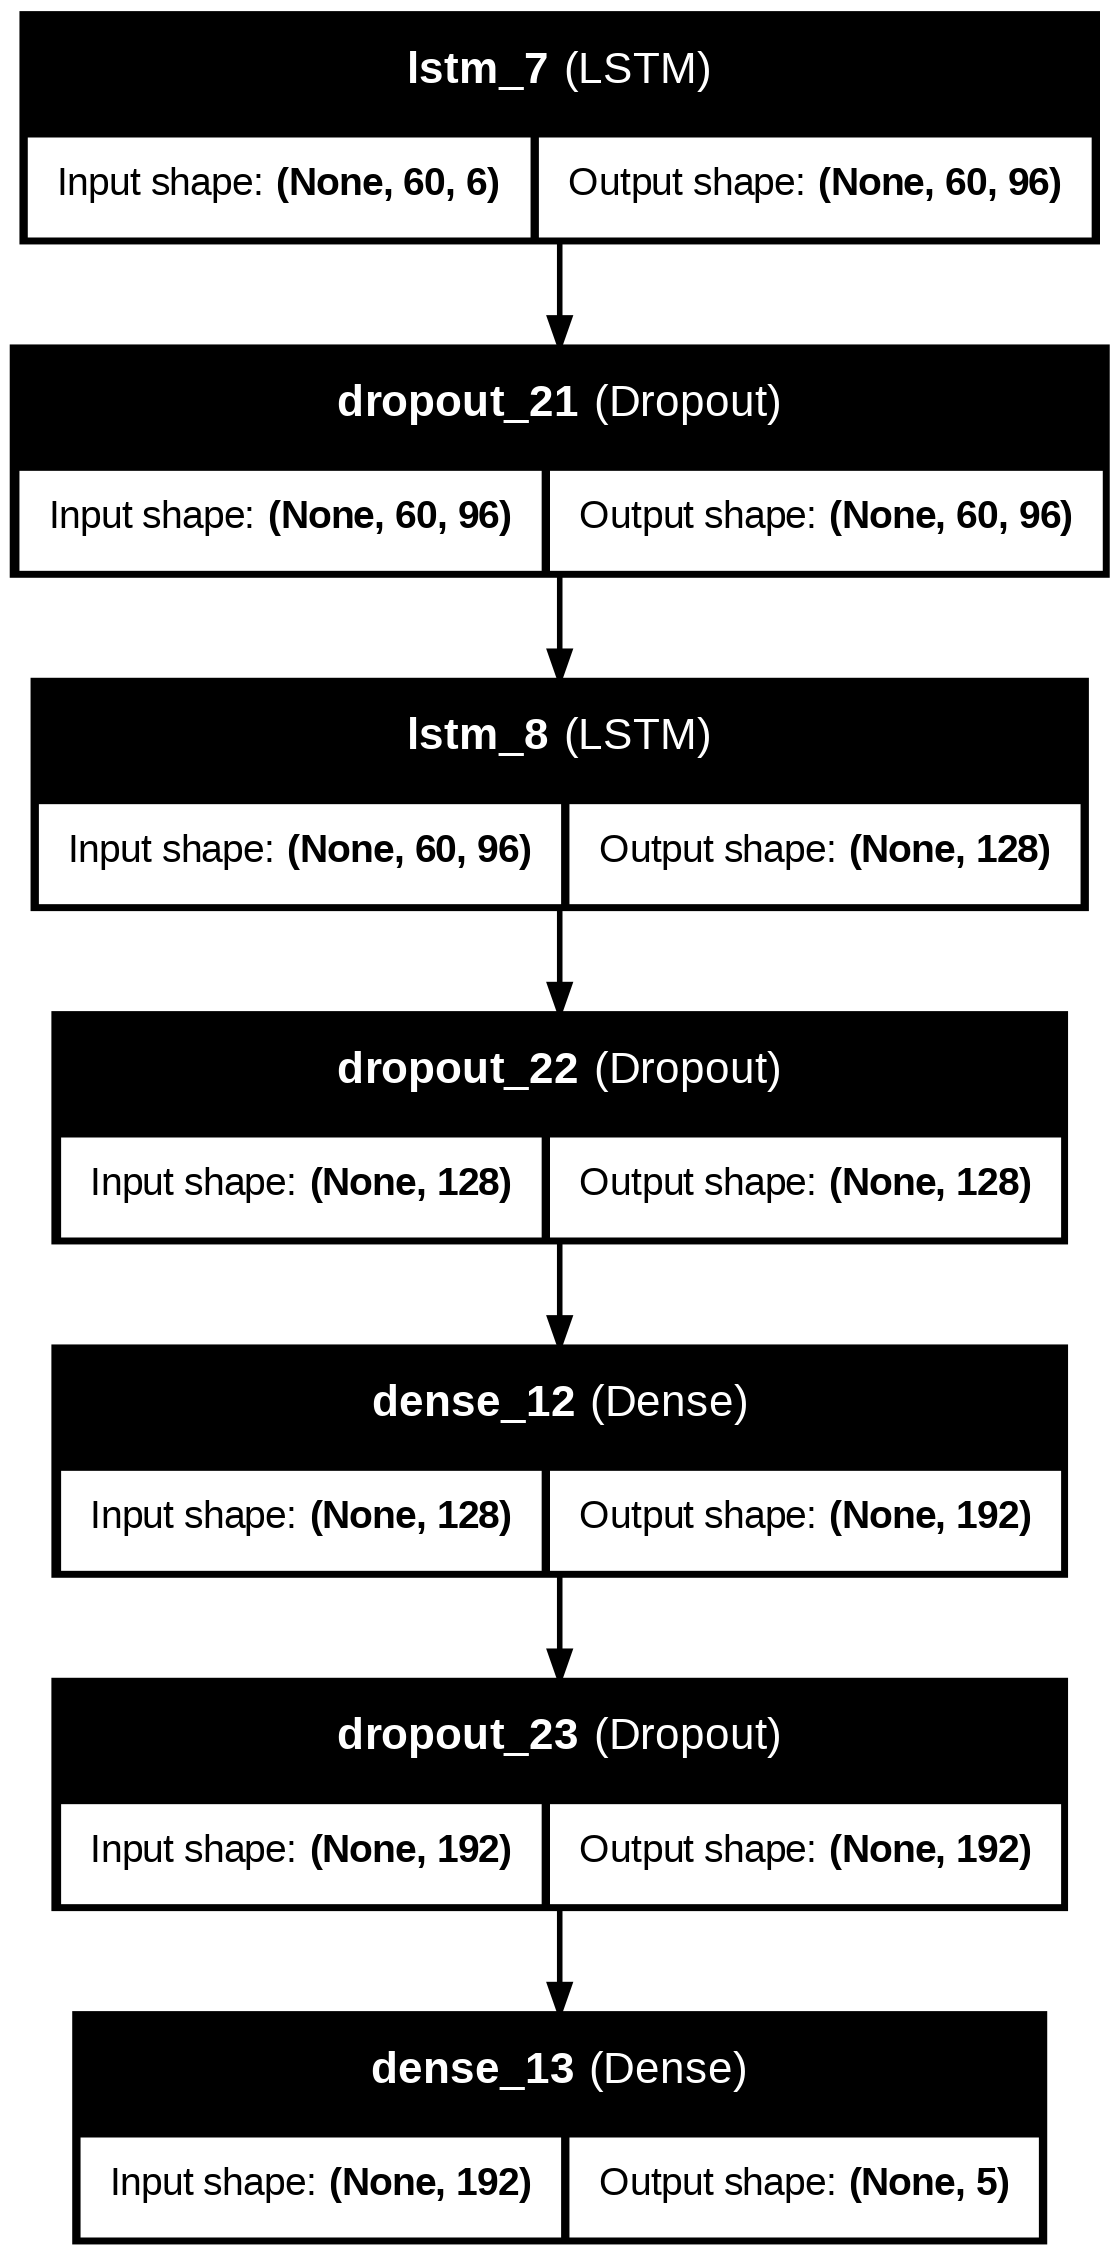

In [ ]:
from tensorflow.keras.utils import plot_model

# Save model plot
plot_model(
    model_lstm,
    to_file="lstm_model_plot.png",
    show_shapes=True,
    show_layer_names=True
)

#LSTM + 1D CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import keras_tuner as kt
import numpy as np

# Reshape from (batch, 6, 60, 1) → (batch, 60, 6)
X_train_cnn_lstm = X_train.reshape((X_train.shape[0], 60, 6))
X_test_cnn_lstm = X_test.reshape((X_test.shape[0], 60, 6))

num_classes = y_train.shape[1]

# HyperModel definition
def build_model(hp):
    model = Sequential([
        # Conv1D Block
        Conv1D(
            filters=hp.Choice('filters', [32, 64, 128]),
            kernel_size=hp.Choice('kernel_size', [3, 5]),
            activation='relu',
            padding='same',
            input_shape=(60, 6)
        ),
        MaxPooling1D(pool_size=2),
        Dropout(hp.Choice('dropout_conv', [0.2, 0.3, 0.4])),

        # LSTM Block
        LSTM(hp.Choice('lstm_units', [32, 64, 128]), return_sequences=False),
        Dropout(hp.Choice('dropout_lstm', [0.2, 0.3, 0.4])),

        # Fully Connected
        Dense(hp.Choice('dense_units', [64, 128, 256]), activation='relu'),
        Dropout(hp.Choice('dropout_dense', [0.3, 0.4, 0.5])),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Random Search Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations
    executions_per_trial=1,
    directory='cnn_lstm_tuning',
    project_name='human_activity'
)

# Run search
tuner.search(
    X_train_cnn_lstm, y_train,
    validation_data=(X_test_cnn_lstm, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

model = tuner.hypermodel.build(best_hps)

# Train with callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HAR Data & Models/wisdm_best_cnn_lstm_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    X_train_cnn_lstm, y_train,
    validation_data=(X_test_cnn_lstm, y_test),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

# # Save final model
# model.save("final_cnn_lstm_model.h5")
# print("Final CNN+LSTM model saved as final_cnn_lstm_model.h5")


Trial 10 Complete [00h 06m 35s]
val_accuracy: 0.8458634614944458

Best val_accuracy So Far: 0.9508143663406372
Total elapsed time: 01h 46m 50s
Best hyperparameters: {'filters': 128, 'kernel_size': 5, 'dropout_conv': 0.3, 'lstm_units': 32, 'dropout_lstm': 0.3, 'dense_units': 64, 'dropout_dense': 0.5, 'learning_rate': 0.001}
Epoch 1/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6407 - loss: 0.8916

580/580 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.6409 - loss: 0.8912 - val_accuracy: 0.8355 - val_loss: 0.3918
Epoch 2/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8474 - loss: 0.4121

580/580 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.8475 - loss: 0.4120 - val_accuracy: 0.8805 - val_loss: 0.3149
Epoch 3/50
578/580 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8860 - loss: 0.3274

580/580 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8860 - loss: 0.3273 - val_accuracy: 0.9195 - val_loss: 0.2189
Epoch 4/50
578/580 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9064 - loss: 0.2700

580/580 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9064 - loss: 0.2700 - val_accuracy: 0.9232 - val_loss: 0.2053
Epoch 5/50
578/580 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9160 - loss: 0.2481

580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9160 - loss: 0.2481 - val_accuracy: 0.9263 - val_loss: 0.1967
Epoch 6/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9191 - loss: 0.2332

580/580 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.9192 - loss: 0.2331 - val_accuracy: 0.9322 - val_loss: 0.1823
Epoch 7/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9250 - loss: 0.2232

580/580 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9250 - loss: 0.2232 - val_accuracy: 0.9352 - val_loss: 0.1804
Epoch 8/50
578/580 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9227 - loss: 0.2153

580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9227 - loss: 0.2152 - val_accuracy: 0.9402 - val_loss: 0.1575
Epoch 9/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9298 - loss: 0.1989 - val_accuracy: 0.9249 - val_loss: 0.1881
Epoch 10/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9334 - loss: 0.1928 - val_accuracy: 0.9392 - val_loss: 0.1650
Epoch 11/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9322 - loss: 0.1934

580/580 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9322 - loss: 0.1933 - val_accuracy: 0.9482 - val_loss: 0.1447
Epoch 12/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9314 - loss: 0.1923 - val_accuracy: 0.9425 - val_loss: 0.1564
Epoch 13/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.9396 - loss: 0.1762 - val_accuracy: 0.9470 - val_loss: 0.1479
Epoch 14/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9392 - loss: 0.1694 - val_accuracy: 0.9457 - val_loss: 0.1501
Epoch 15/50
578/580 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9393 - loss: 0.1717

580/580 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9393 - loss: 0.1717 - val_accuracy: 0.9462 - val_loss: 0.1441
Epoch 16/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9396 - loss: 0.1700

580/580 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.9396 - loss: 0.1700 - val_accuracy: 0.9476 - val_loss: 0.1428
Epoch 17/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9444 - loss: 0.1570 - val_accuracy: 0.9436 - val_loss: 0.1535
Epoch 18/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9460 - loss: 0.1650

580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9460 - loss: 0.1650 - val_accuracy: 0.9479 - val_loss: 0.1419
Epoch 19/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9456 - loss: 0.1542 - val_accuracy: 0.9433 - val_loss: 0.1523
Epoch 20/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9431 - loss: 0.1618

580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9431 - loss: 0.1618 - val_accuracy: 0.9495 - val_loss: 0.1380
Epoch 21/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9447 - loss: 0.1633

580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9447 - loss: 0.1632 - val_accuracy: 0.9506 - val_loss: 0.1333
Epoch 22/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9468 - loss: 0.1503

580/580 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.9467 - loss: 0.1503 - val_accuracy: 0.9495 - val_loss: 0.1292
Epoch 23/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9483 - loss: 0.1458 - val_accuracy: 0.9509 - val_loss: 0.1411
Epoch 24/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9488 - loss: 0.1464 - val_accuracy: 0.9471 - val_loss: 0.1429
Epoch 25/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.9483 - loss: 0.1488 - val_accuracy: 0.9539 - val_loss: 0.1340
Epoch 26/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9464 - loss: 0.1489 - val_accuracy: 0.9492 - val_loss: 0.1382
Epoch 27/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9482 - loss: 0.1492 - val_accuracy: 0.9521 - val_loss: 0.1298


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Reshape input data if not already done
X_train_cnn_lstm = X_train.reshape((X_train.shape[0], 60, 6))
X_test_cnn_lstm = X_test.reshape((X_test.shape[0], 60, 6))

# Number of classes (one-hot encoded y_train)
num_classes = y_train.shape[1]

# Final model with best hyperparameters
model_1d_cnn_lstm = Sequential([
    # Conv1D Block
    Conv1D(
        filters=128,          # best param
        kernel_size=5,        # best param
        activation='relu',
        padding='same',
        input_shape=(60, 6)
    ),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),            # best param

    # LSTM Block
    LSTM(32, return_sequences=False),  # best param
    Dropout(0.3),                      # best param

    # Fully Connected
    Dense(64, activation='relu'),      # best param
    Dropout(0.5),                      # best param

    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile with best learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # best param
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train_cnn_lstm, y_train,
    validation_data=(X_test_cnn_lstm, y_test),
    epochs=20,
    batch_size=64
)

Epoch 1/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6298 - loss: 0.8985 - val_accuracy: 0.1922 - val_loss: 3.1298
Epoch 2/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8627 - loss: 0.3831 - val_accuracy: 0.1920 - val_loss: 2.4413
Epoch 3/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8953 - loss: 0.2949 - val_accuracy: 0.0712 - val_loss: 2.3838
Epoch 4/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9110 - loss: 0.2478 - val_accuracy: 0.1899 - val_loss: 2.7425
Epoch 5/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9198 - loss: 0.2286 - val_accuracy: 0.2859 - val_loss: 2.4645
Epoch 6/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9258 - loss: 0.2110 - val_accuracy: 0.2435 - val_loss: 2.4516
Epoch 7/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9283 - loss: 0.2103 - val_accuracy: 0.2065 - val_loss: 2.7366
Epoch 8/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9330 - loss: 0.1918 - val_accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Precision, Recall, F1 (macro for multi-class)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy : 0.3144
Precision: 0.2152
Recall   : 0.3035
F1 Score : 0.2207


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


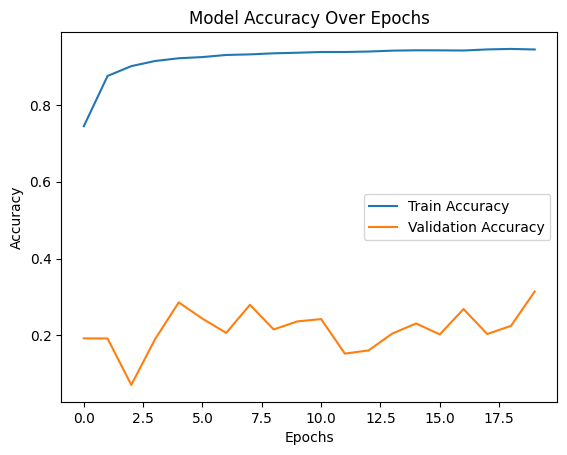

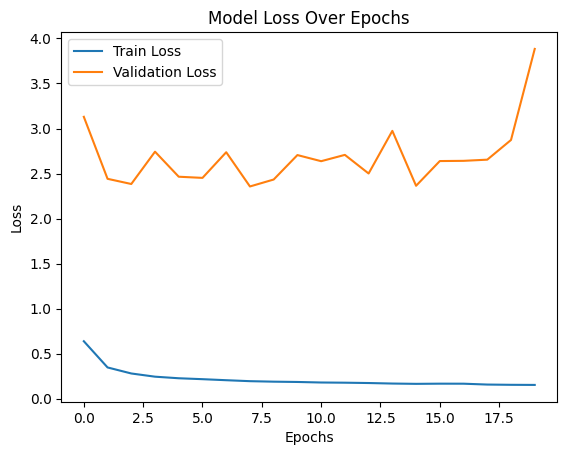

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [ ]:
batch_size = 64
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.3143596351146698
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.29      0.75      0.42       796
     Jogging       0.10      0.03      0.05       652
      Stairs       0.40      0.63      0.49       826
     Sitting       0.30      0.10      0.15       725
    Standing       0.00      0.00      0.00       866

    accuracy                           0.31      3865
   macro avg       0.22      0.30      0.22      3865
weighted avg       0.22      0.31      0.23      3865



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


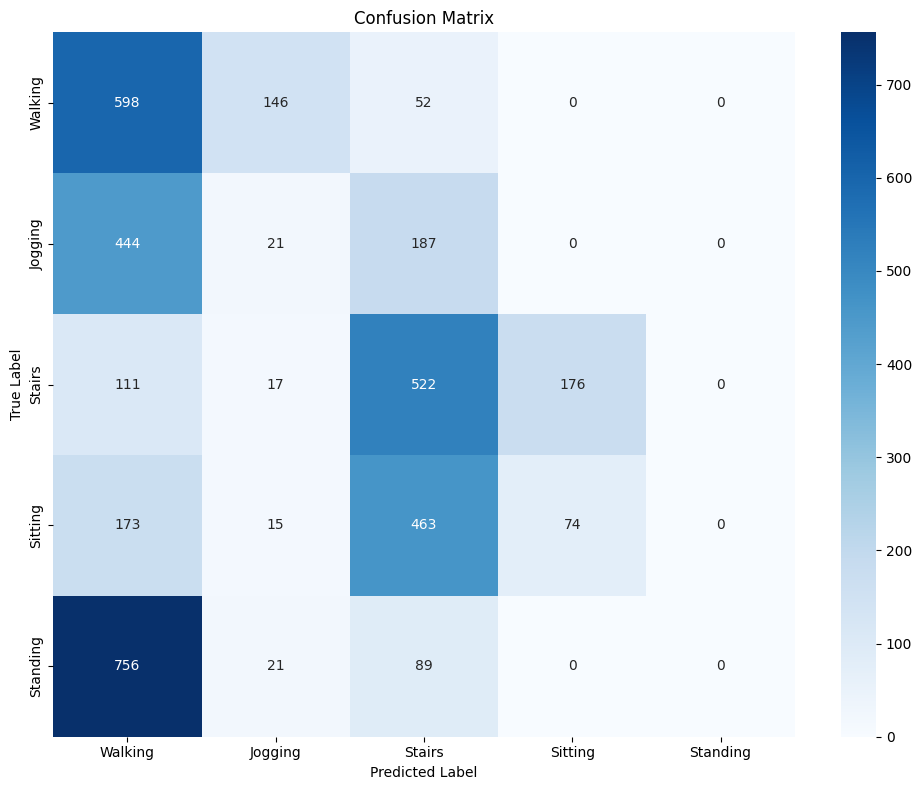

In [ ]:
classNames=['Walking','Jogging','Stairs','Sitting',
    'Standing',
    # 'Writing',
    # 'Eating',
    # 'Playing sports'
]
y_test_labels = np.argmax(y_test, axis=1)

# Convert predictions from probabilities to class labels (integer class labels)
predictions_labels = np.argmax(predictions, axis=1)
display_results(y_test_labels, predictions_labels, classNames)

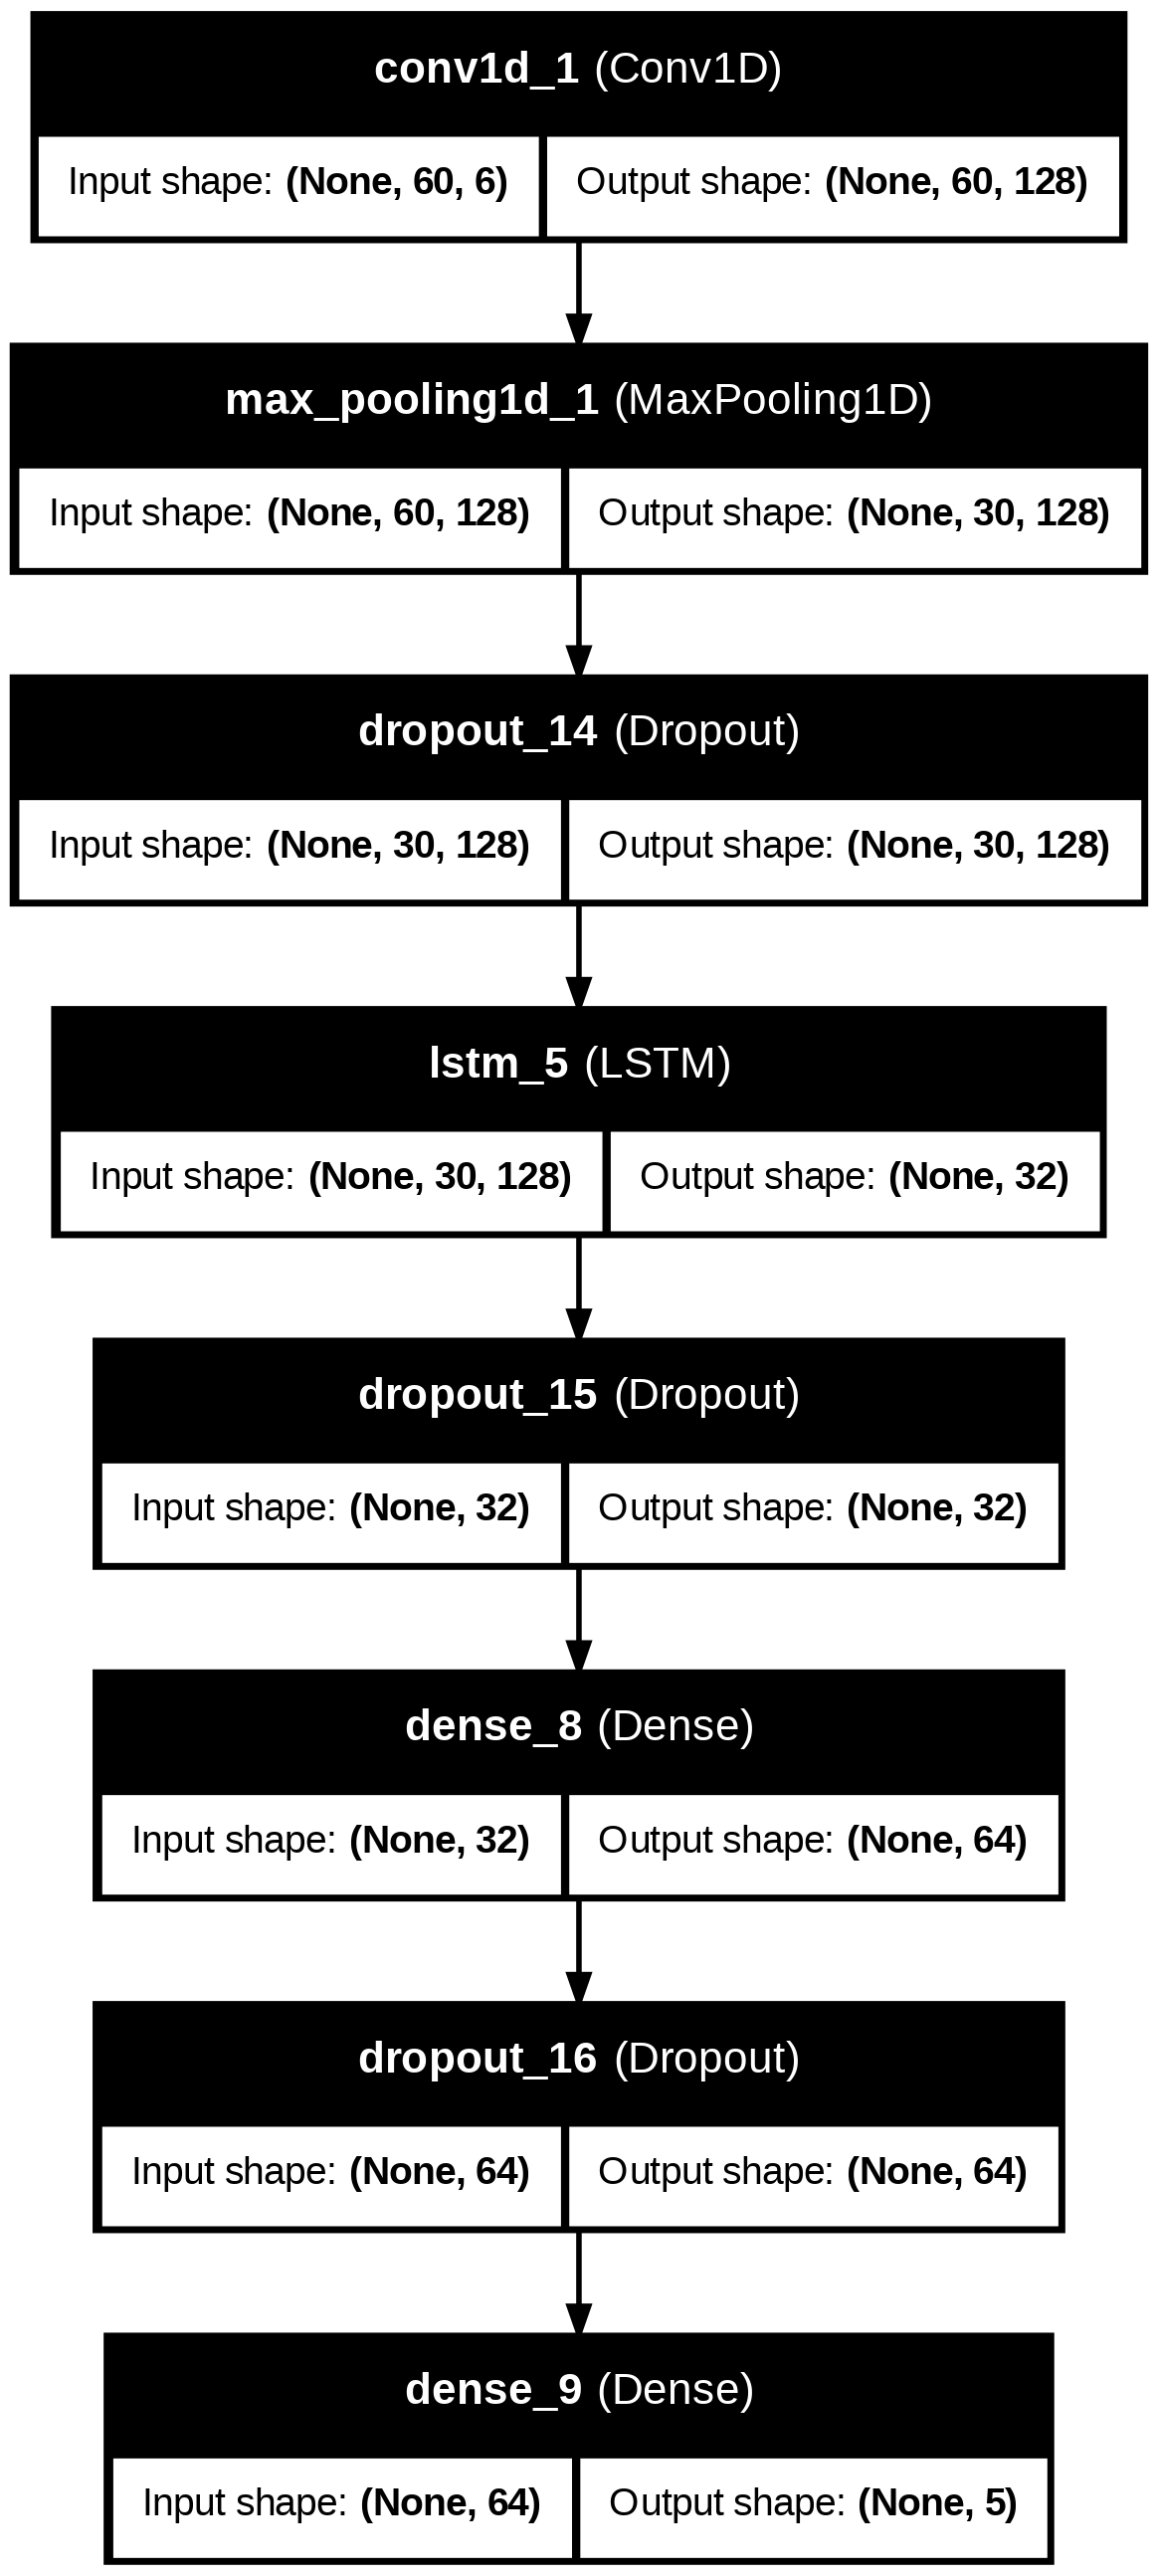

In [ ]:
from tensorflow.keras.utils import plot_model

# Save model plot
plot_model(
    model_1d_cnn_lstm,
    to_file="1dcnn_lstm_model_plot.png",
    show_shapes=True,
    show_layer_names=True
)

#LSTM + 2D CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Dropout, Flatten
import keras_tuner as kt

# Dataset shapes (given)
input_shape = (6, 60, 1)  # height=6, width=60, channels=1
num_classes = y_train.shape[1]

# Build model function for tuner
def build_model(hp):
    model = Sequential([
        # 1st Conv2D block
        Conv2D(
            filters=hp.Choice('filters_1', [32, 64, 128]),
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            input_shape=input_shape
        ),
        MaxPooling2D((2, 2)),
        Dropout(hp.Choice('dropout_1', [0.2, 0.3, 0.4])),

        # 2nd Conv2D block
        Conv2D(
            filters=hp.Choice('filters_2', [32, 64, 128]),
            kernel_size=(3, 3),
            activation='relu',
            padding='same'
        ),
        MaxPooling2D((2, 2)),
        Dropout(hp.Choice('dropout_2', [0.2, 0.3, 0.4])),

        # Flatten + reshape for LSTM
        Flatten(),
        Reshape((hp.Choice('timesteps', [10, 12]), -1)),

        # LSTM
        LSTM(hp.Choice('lstm_units', [32, 64, 96, 128]), return_sequences=False),
        Dropout(hp.Choice('dropout_lstm', [0.2, 0.3, 0.4])),

        # Dense
        Dense(hp.Choice('dense_units', [128, 256]), activation='relu'),
        Dropout(hp.Choice('dropout_dense', [0.3, 0.4, 0.5])),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Random Search tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn2d_lstm_tuning',
    project_name='human_activity'
)

# Run search
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Get best HPs
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

# Build & train final model
model = tuner.hypermodel.build(best_hps)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HAR Data & Models/wisdm_best_cnn2d_lstm_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

# Save final model
# model.save("final_cnn2d_lstm_model.h5")
# print("Final CNN2D+LSTM model saved as final_cnn2d_lstm_model.h5")

Trial 10 Complete [00h 23m 25s]
val_accuracy: 0.9223384857177734

Best val_accuracy So Far: 0.9491963982582092
Total elapsed time: 03h 58m 52s
Best hyperparameters: {'filters_1': 64, 'dropout_1': 0.3, 'filters_2': 64, 'dropout_2': 0.3, 'timesteps': 10, 'lstm_units': 32, 'dropout_lstm': 0.3, 'dense_units': 256, 'dropout_dense': 0.4, 'learning_rate': 0.001}
Epoch 1/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6843 - loss: 0.7687

580/580 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.6844 - loss: 0.7683 - val_accuracy: 0.8677 - val_loss: 0.3402
Epoch 2/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8549 - loss: 0.3756

580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8549 - loss: 0.3756 - val_accuracy: 0.8834 - val_loss: 0.2964
Epoch 3/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8797 - loss: 0.3166

580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8797 - loss: 0.3166 - val_accuracy: 0.9058 - val_loss: 0.2486
Epoch 4/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8947 - loss: 0.2767

580/580 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.8947 - loss: 0.2767 - val_accuracy: 0.9171 - val_loss: 0.2239
Epoch 5/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9054 - loss: 0.2546

580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9054 - loss: 0.2546 - val_accuracy: 0.9192 - val_loss: 0.2135
Epoch 6/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9106 - loss: 0.2398 - val_accuracy: 0.9057 - val_loss: 0.2383
Epoch 7/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.9158 - loss: 0.2272 - val_accuracy: 0.9065 - val_loss: 0.2405
Epoch 8/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9206 - loss: 0.2139

580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9206 - loss: 0.2139 - val_accuracy: 0.9351 - val_loss: 0.1918
Epoch 9/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9258 - loss: 0.1970

580/580 ━━━━━━━━━━━━━━━━━━━━ 81s 69ms/step - accuracy: 0.9258 - loss: 0.1970 - val_accuracy: 0.9259 - val_loss: 0.1832
Epoch 10/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9242 - loss: 0.1953

580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9242 - loss: 0.1953 - val_accuracy: 0.9292 - val_loss: 0.1773
Epoch 11/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9227 - loss: 0.2033

580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.9227 - loss: 0.2032 - val_accuracy: 0.9360 - val_loss: 0.1688
Epoch 12/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9299 - loss: 0.1869 - val_accuracy: 0.9317 - val_loss: 0.1824
Epoch 13/50
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9344 - loss: 0.1795

580/580 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.9344 - loss: 0.1795 - val_accuracy: 0.9419 - val_loss: 0.1463
Epoch 14/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9374 - loss: 0.1712 - val_accuracy: 0.9372 - val_loss: 0.1721
Epoch 15/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9347 - loss: 0.1743 - val_accuracy: 0.9428 - val_loss: 0.1510
Epoch 16/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9358 - loss: 0.1668 - val_accuracy: 0.9391 - val_loss: 0.1542
Epoch 17/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9368 - loss: 0.1655 - val_accuracy: 0.9453 - val_loss: 0.1497
Epoch 18/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.9388 - loss: 0.1602 - val_accuracy: 0.9429 - val_loss: 0.1507


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Dropout, Flatten

# Dataset info
input_shape = (6, 60, 1)   # channels last
num_classes = y_train.shape[1]

# Final model with best hyperparameters
model_2d_cnn_lstm = Sequential([
    # 1st Conv2D block
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=input_shape
    ),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # 2nd Conv2D block
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Flatten + reshape for LSTM
    Flatten(),
    Reshape((10, -1)),   # timesteps = 10

    # LSTM block
    LSTM(32, return_sequences=False),
    Dropout(0.3),

    # Dense layers
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile
model_2d_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with callbacks
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     # # tf.keras.callbacks.ModelCheckpoint(
#     #     '/content/drive/MyDrive/HAR Data & Models/final_best_cnn2d_lstm_model.h5',
#     #     save_best_only=True,
#     #     monitor='val_loss'
#     # )
# ]



# Save final model
# model.save("final_cnn2d_lstm_model.h5")
# print("Final CNN2D+LSTM model saved as final_cnn2d_lstm_model.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=64,
    verbose=1,
    #callbacks=callbacks
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Precision, Recall, F1 (macro for multi-class)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy : 0.1834
Precision: 0.0614
Recall   : 0.1773
F1 Score : 0.0867


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


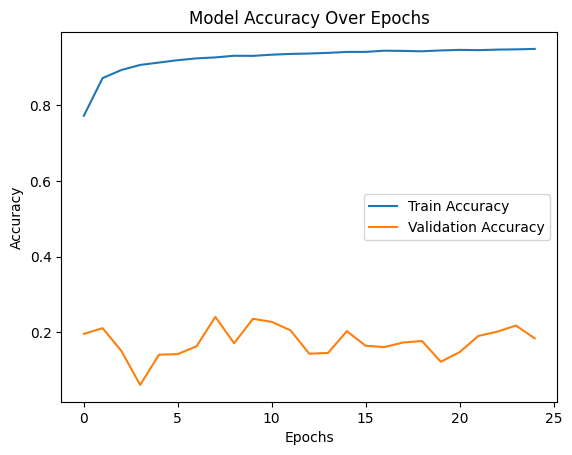

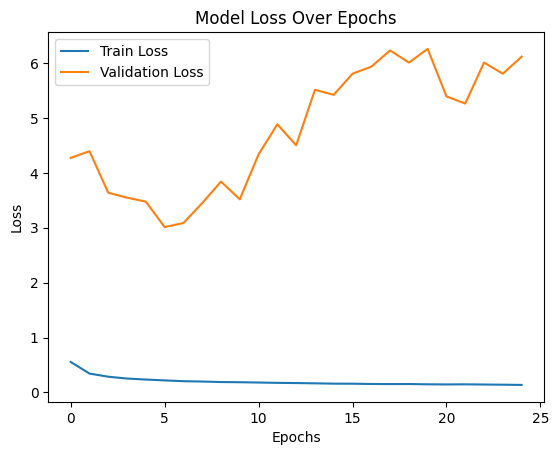

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [ ]:
batch_size = 64
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.1834411323070526
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.21      0.78      0.33       796
     Jogging       0.00      0.00      0.00       652
      Stairs       0.10      0.11      0.10       826
     Sitting       0.00      0.00      0.00       725
    Standing       0.00      0.00      0.00       866

    accuracy                           0.18      3865
   macro avg       0.06      0.18      0.09      3865
weighted avg       0.06      0.18      0.09      3865



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


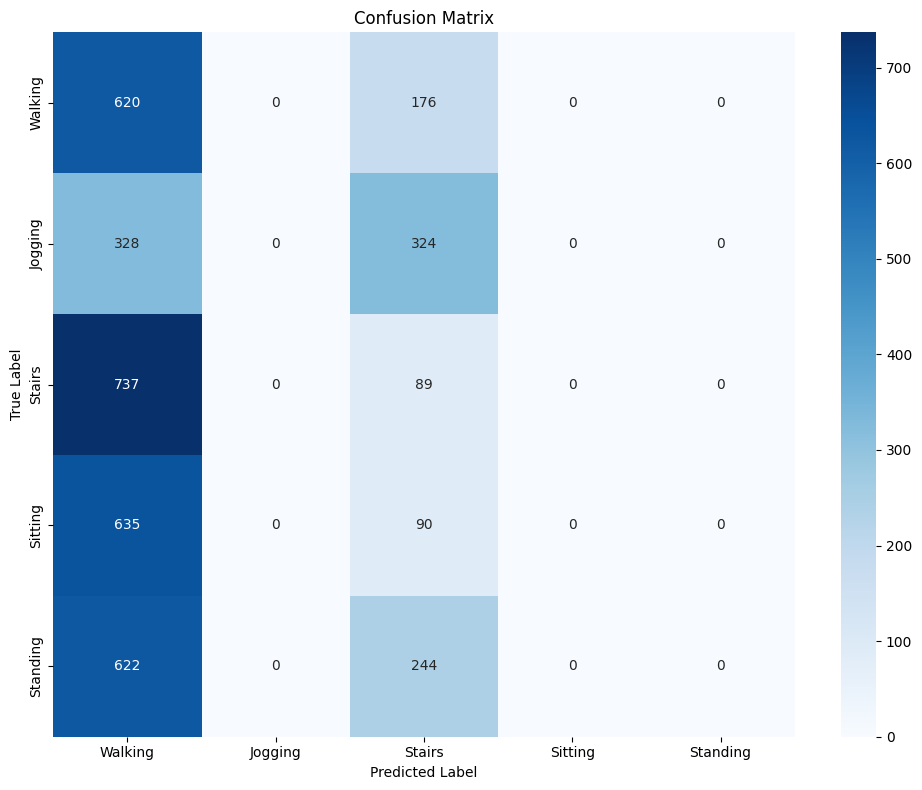

In [ ]:
classNames=['Walking','Jogging','Stairs','Sitting',
    'Standing',
    # 'Writing',
    # 'Eating',
    # 'Playing sports'
]
y_test_labels = np.argmax(y_test, axis=1)

# Convert predictions from probabilities to class labels (integer class labels)
predictions_labels = np.argmax(predictions, axis=1)
display_results(y_test_labels, predictions_labels, classNames)

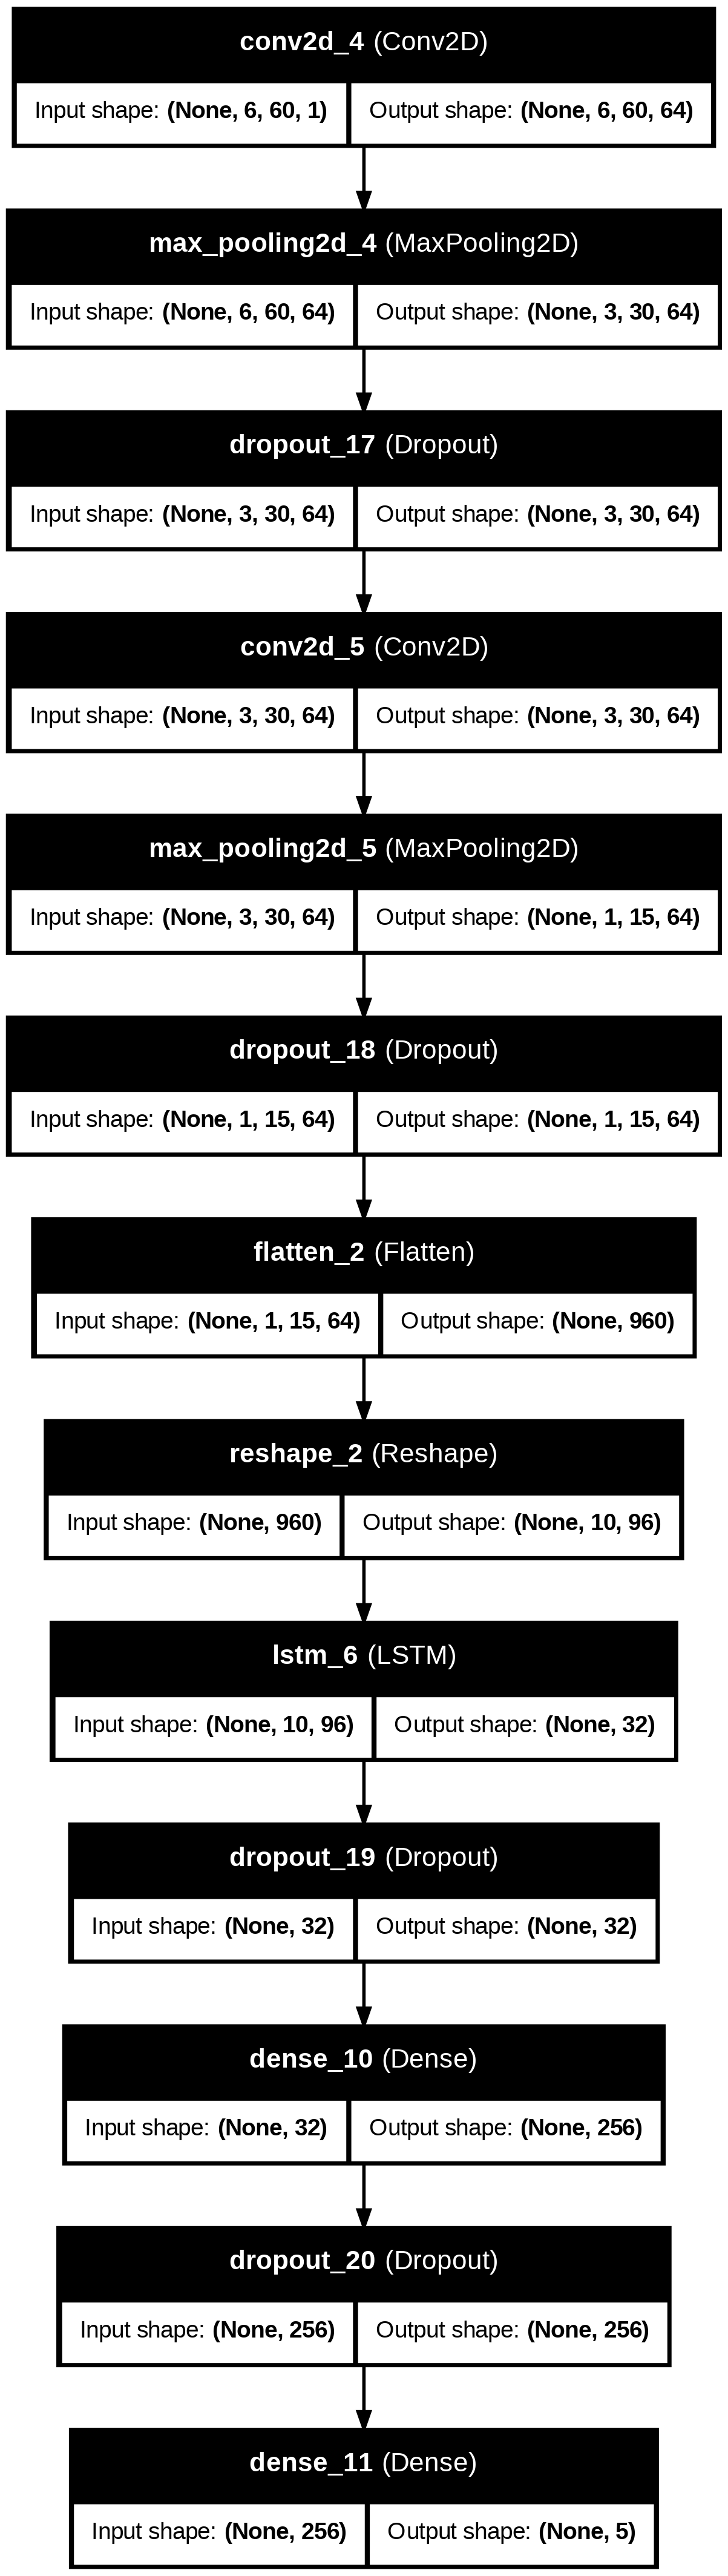

In [ ]:
from tensorflow.keras.utils import plot_model

# Save model plot
plot_model(
    model_2d_cnn_lstm,
    to_file="2dcnn_lstm_model_plot.png",
    show_shapes=True,
    show_layer_names=True
)
